In [1]:
import psutil

mem = psutil.virtual_memory()
print(f"Total RAM: {mem.total / 1e9:.2f} GB")
print(f"Available: {mem.available / 1e9:.2f} GB")

Total RAM: 810.42 GB
Available: 750.84 GB


In [2]:
# !pip uninstall -y scikit-learn
# !pip install scikit-learn==1.3.1

In [3]:
# ! pip install --upgrade pip
# ! pip install --user xgboost seaborn
# ! pip install --user bayesian-optimization

In [4]:
# import mplhep
import sys

import seaborn as sns

import numpy as np
import pandas as pd
import uproot
from matplotlib import pyplot as plt

from sklearn.datasets import make_classification,make_regression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc,roc_curve,confusion_matrix,classification_report,precision_recall_curve,mean_squared_error,accuracy_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate, validation_curve,train_test_split,KFold,learning_curve,cross_val_score
from sklearn.utils import compute_sample_weight
from scipy.stats import ks_2samp

import xgboost
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint, uniform

In [5]:
plt.rcParams.update({
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 16,
    "figure.titlesize": 20
})

In [6]:
pd.set_option('display.max_rows', 200000)
pd.set_option('display.max_columns', 200000)

In [7]:
sys.path.append("/home/belle2/amubarak/Ds2D0enue_Analysis/07-Python_Functions/")

# Prep-Work

### Import Data

Correct Charge

In [8]:
import os
import uproot
import pandas as pd

# === Load only selected branches ===
with open("/home/belle2/amubarak/Ds2D0enue_Analysis/03-Grid/Save_var.txt") as f:
    variables_to_load = [
        line.strip().strip(",").strip('"').strip("'")
        for line in f
        if line.strip() and not line.strip().startswith("#")
    ]

# Make sure to include BDT output variable
if "Ds_FakeD0BDT" not in variables_to_load:
    variables_to_load.append("Ds_FakeD0BDT")

# === Sample list ===
samples = ["Signal", "BB", "ccbar", "ddbar", "ssbar", "taupair", "uubar"]
GenEvents = samples.copy()

# === Input configuration ===
Date = "0530"
Attempt = "0"
input_dir = "/group/belle/users/amubarak/03-ML/FakeD0/"

# === Load ROOT files into DataFrames ===
DataFrames = {}

for s in samples:
    if s == "Signal":
        file_path = os.path.join(input_dir, "Ds2D0enu-Signal_withBDT.root")
    else:
        file_path = os.path.join(
            input_dir, f"Ds2D0e-Generic_Ds_{Date}25_{Attempt}_{s}_withBDT.root"
        )

    print(f"Loading: {file_path}")
    DataFrames[s] = uproot.concatenate(
        f"{file_path}:Dstree",
        filter_name=variables_to_load,
        library="pd"
    )

# === Define combined background ===
background_samples = ["BB", "ccbar", "ddbar", "ssbar", "taupair", "uubar"]
DataFrames["All"] = pd.concat([DataFrames[s] for s in background_samples], ignore_index=True)

# === Combine uds backgrounds for convenience ===
DataFrames["uds"] = pd.concat(
    [DataFrames["uubar"], DataFrames["ddbar"], DataFrames["ssbar"]],
    ignore_index=True
)

Loading: /group/belle/users/amubarak/03-ML/FakeD0/Ds2D0enu-Signal_withBDT.root
Loading: /group/belle/users/amubarak/03-ML/FakeD0/Ds2D0e-Generic_Ds_053025_0_BB_withBDT.root
Loading: /group/belle/users/amubarak/03-ML/FakeD0/Ds2D0e-Generic_Ds_053025_0_ccbar_withBDT.root
Loading: /group/belle/users/amubarak/03-ML/FakeD0/Ds2D0e-Generic_Ds_053025_0_ddbar_withBDT.root
Loading: /group/belle/users/amubarak/03-ML/FakeD0/Ds2D0e-Generic_Ds_053025_0_ssbar_withBDT.root
Loading: /group/belle/users/amubarak/03-ML/FakeD0/Ds2D0e-Generic_Ds_053025_0_taupair_withBDT.root
Loading: /group/belle/users/amubarak/03-ML/FakeD0/Ds2D0e-Generic_Ds_053025_0_uubar_withBDT.root


Wrong Charge

In [9]:
# import os
# import uproot
# import pandas as pd

# # === Load only selected branches ===
# with open("/home/belle2/amubarak/Ds2D0enue_Analysis/03-Grid/Save_var.txt") as f:
#     variables_to_load = [
#         line.strip().strip(",").strip('"').strip("'")
#         for line in f
#         if line.strip() and not line.strip().startswith("#")
#     ]

# # Ensure BDT variable is included
# if "Ds_FakeD0BDT" not in variables_to_load:
#     variables_to_load.append("Ds_FakeD0BDT")

# # === Wrong-charge samples ===
# samples_WCh = ["Signal_WCh", "BB_WCh", "ccbar_WCh", "ddbar_WCh", "ssbar_WCh", "taupair_WCh", "uubar_WCh", "Data_WCh"]
# background_WCh = ["BB_WCh", "ccbar_WCh", "ddbar_WCh", "ssbar_WCh", "taupair_WCh", "uubar_WCh"]

# Date_WCh = "0630"
# Attempt_WCh = "0"
# input_dir_WCh = "/group/belle/users/amubarak/03-ML/FakeD0_WCh/"

# # === Load wrong-charge ROOT files into DataFrames ===
# DataFrames = {} if "DataFrames" not in globals() else DataFrames

# for s in samples_WCh:
#     if s == "Signal_WCh":
#         file_path = os.path.join(input_dir_WCh, "Ds2D0enu-Signal_WCh_withBDT.root")
#     else:
#         tag = s.replace("_WCh", "")
#         file_path = os.path.join(
#             input_dir_WCh,
#             f"Ds2D0e-Generic_Ds_{Date_WCh}25_{Attempt_WCh}_{tag}_withBDT.root"
#         )

#     print(f"Loading: {file_path}")
#     DataFrames[s] = uproot.concatenate(
#         f"{file_path}:Dstree",
#         filter_name=variables_to_load,
#         library="pd"
#     )

# # === Combine wrong-charge backgrounds ===
# DataFrames["All_WCh"] = pd.concat([DataFrames[s] for s in background_WCh], ignore_index=True)
# DataFrames["uds_WCh"] = pd.concat(
#     [DataFrames[s] for s in ["uubar_WCh", "ddbar_WCh", "ssbar_WCh"]],
#     ignore_index=True
# )

Reverse PID

In [10]:
# import os
# import uproot
# import numpy as np
# import pandas as pd

# # === Load only selected branches ===
# with open("/home/belle2/amubarak/Ds2D0enue_Analysis/03-Grid/Save_var.txt") as f:
#     variables_to_load = [
#         line.strip().strip(",").strip('"').strip("'")
#         for line in f
#         if line.strip() and not line.strip().startswith("#")
#     ]

# # Ensure BDT variable is included
# if "Ds_FakeD0BDT" not in variables_to_load:
#     variables_to_load.append("Ds_FakeD0BDT")

# # === Ask user for reduction options ===
# reduce_signal = input("Load only 1% of SIGNAL? (y/n): ").strip().lower() == "y"
# reduce_bkg    = input("Load only 1% of BACKGROUND? (y/n): ").strip().lower() == "y"
# reduce_data   = input("Load only 1% of DATA? (y/n): ").strip().lower() == "y"

# # === Reverse-PID samples ===
# samples_ReverseID = [
#     "Signal_ReverseID", "BB_ReverseID", "ccbar_ReverseID",
#     "ddbar_ReverseID", "ssbar_ReverseID", "taupair_ReverseID",
#     "uubar_ReverseID", "Data_ReverseID"
# ]

# background_ReverseID = [
#     "BB_ReverseID", "ccbar_ReverseID", "ddbar_ReverseID",
#     "ssbar_ReverseID", "taupair_ReverseID", "uubar_ReverseID"
# ]

# Date_ReverseID = "0626"
# Attempt_ReverseID = "0"
# input_dir_ReverseID = "/group/belle/users/amubarak/03-ML/FakeD0_ReverseID/"

# # === Load wrong-charge ROOT files into DataFrames ===
# DataFrames = {} if "DataFrames" not in globals() else DataFrames

# for s in samples_ReverseID:
#     # === Build path
#     if s == "Signal_ReverseID":
#         file_path = os.path.join(input_dir_ReverseID, "Ds2D0enu-Signal_ReverseID_withBDT.root")
#     else:
#         tag = s.replace("_ReverseID", "")
#         file_path = os.path.join(
#             input_dir_ReverseID,
#             f"Ds2D0e-Generic_Ds_{Date_ReverseID}25_{Attempt_ReverseID}_{tag}_withBDT.root"
#         )

#     print(f"Loading: {file_path}")

#     # === Figure out how many entries to load
#     with uproot.open(file_path) as f:
#         total_entries = f["Dstree"].num_entries

#     # === Decide reduction based on category
#     if s == "Signal_ReverseID" and reduce_signal:
#         entry_stop = int(total_entries * 0.01)
#     elif s in background_ReverseID and reduce_bkg:
#         entry_stop = int(total_entries * 0.01)
#     elif s == "Data_ReverseID" and reduce_data:
#         entry_stop = int(total_entries * 0.01)
#     else:
#         entry_stop = total_entries

#     # === Load only up to entry_stop using uproot.iterate
#     df_chunks = uproot.iterate(
#         f"{file_path}:Dstree",
#         filter_name=variables_to_load,
#         library="pd",
#         entry_start=0,
#         entry_stop=entry_stop,
#         step_size=100000  # <-- fixed size in entries
#     )
#     df = pd.concat(list(df_chunks), ignore_index=True)

#     DataFrames[s] = df
#     print(f"✔️ {s}: loaded {len(df):,} entries (of {total_entries:,})")

# # === Combine background categories
# DataFrames["All_ReverseID"] = pd.concat(
#     [DataFrames[s] for s in background_ReverseID],
#     ignore_index=True
# )

# # === Combine uds categories
# DataFrames["uds_ReverseID"] = pd.concat(
#     [DataFrames[s] for s in ["uubar_ReverseID", "ddbar_ReverseID", "ssbar_ReverseID"]],
#     ignore_index=True
# )

In [11]:
# import os
# import uproot
# import pandas as pd

# # === Load only selected branches ===
# with open("/home/belle2/amubarak/Ds2D0enue_Analysis/03-Grid/Save_var.txt") as f:
#     variables_to_load = [
#         line.strip().strip(",").strip('"').strip("'")
#         for line in f
#         if line.strip() and not line.strip().startswith("#")
#     ]

# # Ensure BDT variable is included
# if "Ds_FakeD0BDT" not in variables_to_load:
#     variables_to_load.append("Ds_FakeD0BDT")

# # === Reverse-PID samples ===
# samples_ReverseID = ["Signal_ReverseID", "BB_ReverseID", "ccbar_ReverseID", "ddbar_ReverseID", "ssbar_ReverseID", "taupair_ReverseID", "uubar_ReverseID", "Data_ReverseID"]
# background_ReverseID = ["BB_ReverseID", "ccbar_ReverseID", "ddbar_ReverseID", "ssbar_ReverseID", "taupair_ReverseID", "uubar_ReverseID"]

# Date_ReverseID = "0626"
# Attempt_ReverseID = "0"
# input_dir_ReverseID = "/group/belle/users/amubarak/03-ML/FakeD0_ReverseID/"

# # === Load wrong-charge ROOT files into DataFrames ===
# DataFrames = {} if "DataFrames" not in globals() else DataFrames

# for s in samples_ReverseID:
#     if s == "Signal_ReverseID":
#         file_path = os.path.join(input_dir_ReverseID, "Ds2D0enu-Signal_ReverseID_withBDT.root")
#     else:
#         tag = s.replace("_ReverseID", "")
#         file_path = os.path.join(
#             input_dir_ReverseID,
#             f"Ds2D0e-Generic_Ds_{Date_ReverseID}25_{Attempt_ReverseID}_{tag}_withBDT.root"
#         )

#     print(f"Loading: {file_path}")
#     DataFrames[s] = uproot.concatenate(
#         f"{file_path}:Dstree",
#         filter_name=variables_to_load,
#         library="pd"
#     )

# # === Combine wrong-charge backgrounds ===
# DataFrames["All_ReverseID"] = pd.concat([DataFrames[s] for s in background_ReverseID], ignore_index=True)
# DataFrames["uds_ReverseID"] = pd.concat(
#     [DataFrames[s] for s in ["uubar_ReverseID", "ddbar_ReverseID", "ssbar_ReverseID"]],
#     ignore_index=True
# )

Reverse PID and Wrong Charge

In [12]:
# import os
# import uproot
# import pandas as pd

# # === Load only selected branches ===
# with open("/home/belle2/amubarak/Ds2D0enue_Analysis/03-Grid/Save_var.txt") as f:
#     variables_to_load = [
#         line.strip().strip(",").strip('"').strip("'")
#         for line in f
#         if line.strip() and not line.strip().startswith("#")
#     ]

# # Ensure BDT variable is included
# if "Ds_FakeD0BDT" not in variables_to_load:
#     variables_to_load.append("Ds_FakeD0BDT")

# # === Wrong-charge samples ===
# samples_ReverseID_WCh = ["BB_ReverseID_WCh", "ccbar_ReverseID_WCh", "ddbar_ReverseID_WCh", "ssbar_ReverseID_WCh", "taupair_ReverseID_WCh", "uubar_ReverseID_WCh", "Data_ReverseID_WCh"]
# background_ReverseID_WCh = ["BB_ReverseID_WCh", "ccbar_ReverseID_WCh", "ddbar_ReverseID_WCh", "ssbar_ReverseID_WCh", "taupair_ReverseID_WCh", "uubar_ReverseID_WCh"]

# Date_ReverseID_WCh = "0708"
# Attempt_ReverseID_WCh = "0"
# input_dir_ReverseID_WCh = "/group/belle/users/amubarak/03-ML/FakeD0_ReverseID_WCh/"

# # === Load wrong-charge ROOT files into DataFrames ===
# DataFrames = {} if "DataFrames" not in globals() else DataFrames

# for s in samples_ReverseID_WCh:
#     if s == "Signal_ReverseID_WCh":
#         file_path = os.path.join(input_dir_ReverseID_WCh, "Ds2D0enu-Signal_ReverseID_WCh_withBDT.root")
#     else:
#         tag = s.replace("_ReverseID_WCh", "")
#         file_path = os.path.join(
#             input_dir_ReverseID_WCh,
#             f"Ds2D0e-Generic_Ds_{Date_ReverseID_WCh}25_{Attempt_ReverseID_WCh}_{tag}_withBDT.root"
#         )

#     print(f"Loading: {file_path}")
#     DataFrames[s] = uproot.concatenate(
#         f"{file_path}:Dstree",
#         filter_name=variables_to_load,
#         library="pd"
#     )

# # === Combine wrong-charge backgrounds ===
# DataFrames["All_ReverseID_WCh"] = pd.concat([DataFrames[s] for s in background_ReverseID_WCh], ignore_index=True)
# DataFrames["uds_ReverseID_WCh"] = pd.concat(
#     [DataFrames[s] for s in ["uubar_ReverseID_WCh", "ddbar_ReverseID_WCh", "ssbar_ReverseID_WCh"]],
#     ignore_index=True
# )

The line below is to look at the available variables.

In [13]:
# === Inject derived variables ===
for key in DataFrames:
    df = DataFrames[key]

    DataFrames[key]["log_e_p"] = np.log(df["e_p"].replace(0, np.nan))
    DataFrames[key]["pe_ratio"] = df["D0_p"] / df["e_p"].replace(0, np.nan)

    # Only compute significance if both components exist and it's not a Data sample
    if not key.startswith("Data"):
        if "Ds_vertexDistanceOfDaughter_0" in df.columns and "Ds_vertexDistanceOfDaughterErr_0" in df.columns:
            DataFrames[key]["Ds_vertexDistanceSignificance_0"] = (
                df["Ds_vertexDistanceOfDaughter_0"] / df["Ds_vertexDistanceOfDaughterErr_0"].replace(0, np.nan)
            )

In [14]:
print(DataFrames.keys())

dict_keys(['Signal', 'BB', 'ccbar', 'ddbar', 'ssbar', 'taupair', 'uubar', 'All', 'uds'])


In [15]:
DataFrames['Signal'].columns.tolist()

['__experiment__',
 '__run__',
 '__event__',
 '__candidate__',
 '__ncandidates__',
 'e_isCurl',
 'e_isTruthCurl',
 'e_angleToClosestInList_e_gen',
 'e_closestInList_e_gen_mcPDG',
 'e_closestInList_e_gen_genMotherPDG',
 'e_closestInList_e_gen_pt',
 'e_closestInList_e_gen_px',
 'e_closestInList_e_gen_py',
 'e_closestInList_e_gen_pz',
 'e_closestInList_pi_gen_mcPDG',
 'e_closestInList_pi_gen_genMotherPDG',
 'e_closestInList_pi_gen_pt',
 'e_closestInList_pi_gen_px',
 'e_closestInList_pi_gen_py',
 'e_closestInList_pi_gen_pz',
 'e_clusterE1E9',
 'e_clusterE9E21',
 'e_trackFitCovariance_0_2',
 'e_trackFitCovariance_2_3',
 'e_trackFitCovariance_0_3',
 'e_trackFitHypothesisPDG',
 'e_chi2',
 'e_ndf',
 'e_trackTime',
 'e_pionID',
 'e_electronID',
 'e_binaryPID_11_211',
 'e_omega',
 'e_daughter_0_isCloneTrack',
 'e_flightTime',
 'e_formula_E_p',
 'e_mcVirtual',
 'e_isMisidentified',
 'e_pminusptrue_p',
 'e_pminusptrue_old',
 'e_mcMother_E',
 'e_mcMother_p',
 'e_mcMother_mcDecayVertexFromIPDistance

### Setup
The code below will be used to apply cuts to the data.  
The range of the plots.

In [16]:
# Electron ID
#-------------------
# DataFrames["Signal"] = DataFrames["Signal"][DataFrames["Signal"]['e_electronID']>=0.95]
# DataFrames["ccbar"] = DataFrames["ccbar"][DataFrames["ccbar"]['e_electronID']>=0.95]
# DataFrames["Signal"] = DataFrames["Signal"][DataFrames["Signal"]['Ds_gammaveto_em_electronID']>=0.95]
# DataFrames["ccbar"] = DataFrames["ccbar"][DataFrames["ccbar"]['Ds_gammaveto_em_electronID']>=0.95]

# # Photon Conversion
# #-------------------
# for key in DataFrames.keys():
#     df = DataFrames[key]
#     if "Ds_gammaveto_M_Correction" in df.columns:
#         DataFrames[key] = df[
#             (df["e_p"] >= 0.043)
#         ]

# Peaking Background Removal
#----------------------------
# DataFrames["ccbar"] = DataFrames["ccbar"][(DataFrames["ccbar"]['Ds_diff_D0pi']>=0.15)]
# DataFrames["Signal"] = DataFrames["Signal"][(DataFrames["Signal"]['Ds_diff_D0pi']>=0.15)]

# # Vertex Fitting
# #----------------
# DataFrames["Signal"] = DataFrames["Signal"][DataFrames["Signal"]['Ds_chiProb']>=0.01]
# DataFrames["ccbar"] = DataFrames["ccbar"][DataFrames["ccbar"]['Ds_chiProb']>=0.01]

# Dalitz Removal
#----------------------------
# DataFrames["ccbar"] = DataFrames["ccbar"][(DataFrames["ccbar"]['Ds_pi0veto_M_Correction']<=0.08) | (DataFrames["ccbar"]['Ds_pi0veto_M_Correction']>=0.16)]
# DataFrames["Signal"] = DataFrames["Signal"][(DataFrames["Signal"]['Ds_pi0veto_M_Correction']<=0.08) | (DataFrames["Signal"]['Ds_pi0veto_M_Correction']>=0.16)]

# Vertex Fit
#----------------
for key in DataFrames.keys():
    df = DataFrames[key]
    if "Ds_chiProb_Ds_rank" in df.columns:
        DataFrames[key] = df[
            (df['Ds_chiProb_Ds_rank'] == 1)
        ]

# D0 Invariant Mass
#-----------------------
# DataFrames[samples[0]] = DataFrames[samples[0]][(DataFrames[samples[0]]['Ds_D0_sideband']==1)]
# DataFrames[samples[1]] = DataFrames[samples[1]][(DataFrames[samples[1]]['Ds_D0_sideband']==1)]

## $D^{*+}$ Suppression

In [17]:
# print(abs(DataFrames["All_ReverseID"][(DataFrames["All_ReverseID"]["e_electronID"] < 0.5)])[['e_mcPDG']].value_counts(normalize=True,dropna=False).apply(lambda x: f"{x:.6f}"))

In [18]:
# cut_low = 0.14543 - (2 * 0.00041121)
# cut_high = 0.14543 + (2 * 0.00041121)

# for key in DataFrames.keys():
#     df = DataFrames[key]
#     if "Ds_diff_D0pi" in df.columns:
#         DataFrames[key] = df[
#             (df["Ds_diff_D0pi"] <= cut_low) | (df["Ds_diff_D0pi"] >= cut_high)
#         ]

In [19]:
DataFrames["All"]["D0_isSignal"] = DataFrames["All"]["D0_isSignal"].replace(np.nan, 0)

for s in GenEvents[0:]: # loop over samples
    DataFrames[s]["D0_isSignal"] = DataFrames[s]["D0_isSignal"].replace(np.nan, 0)

In [20]:
DataFrames["All"]["Ds_isSignal"] = DataFrames["All"]["Ds_isSignal"].replace(np.nan, 0)

for s in GenEvents[0:]: # loop over samples
    DataFrames[s]["Ds_isSignal"] = DataFrames[s]["Ds_isSignal"].replace(np.nan, 0)

## Fake $D^0$ BDT Cut

In [21]:
# for key in DataFrames.keys():
#     df = DataFrames[key]
#     if "Ds_FakeD0BDT" in df.columns:
#         DataFrames[key] = df[
#             (df["Ds_FakeD0BDT"] >= 0.5)
#         ]

# Background Suppression

In [22]:
DataFrames[samples[0]].isna().sum()

__experiment__                                             0
__run__                                                    0
__event__                                                  0
__candidate__                                              0
__ncandidates__                                            0
e_isCurl                                                   0
e_isTruthCurl                                              0
e_angleToClosestInList_e_gen                               0
e_closestInList_e_gen_mcPDG                                0
e_closestInList_e_gen_genMotherPDG                         0
e_closestInList_e_gen_pt                                   0
e_closestInList_e_gen_px                                   0
e_closestInList_e_gen_py                                   0
e_closestInList_e_gen_pz                                   0
e_closestInList_pi_gen_mcPDG                               0
e_closestInList_pi_gen_genMotherPDG                        0
e_closestInList_pi_gen_p

In [23]:
print("Signal Number: ",len(DataFrames["Signal"]))
print("Background Number: ",len(DataFrames["All"]))

Signal Number:  170685
Background Number:  1291946


## Variable Comparison

In [24]:
plt.style.use('default')
plt.rcParams.update({
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 14,
    "figure.titlesize": 18
})

In [25]:
# # === Input Variables and Labels ===
# Variables = [
#     "Ds_FakeD0BDT",
#     "Ds_chiProb",
#     "Ds_gammaveto_M_Correction",
#     "Ds_Ds_starminusDs_M_Correction"
# ]

# features = [
#     r'$Fake\;D^{0}\;Suppression$',
#     r'$p$-value$_{IP}(D_{s}^{+})$',
#     r'$m(e_{\mathrm{sig}}^{+}e_{\mathrm{ROE}}^{-})\;[\mathrm{GeV}/c^2]$',
#     r'$\Delta m(D_{s}^{*+} - D_{s}^{+})\;[\mathrm{GeV}/c^2]$'
# ]

# # === Plot Ranges ===
# ranges = {
#     "Ds_FakeD0BDT": [0.0, 1.0],
#     "Ds_chiProb": [0.0, 1.0],
#     "Ds_gammaveto_M_Correction": [0.0, 0.2],
#     "Ds_Ds_starminusDs_M_Correction": [0.0, 0.2]
# }

# bins = 50
# density = True

# # === Colors and Labels ===
# colors = {
#     "signal": "#1f77b4",     # Blue
#     "background": "#d62728"  # Red
# }
# labels = {
#     "signal": r'$Signal$',
#     "background": r'$Background$'
# }

# # === Extract real signal and background ===
# df_true_signal = DataFrames["Signal"][DataFrames["Signal"]["Ds_isSignal"] == 1]
# df_background = DataFrames["All"]

# # === Plotting ===
# for var, label in zip(Variables, features):
#     if var not in ranges:
#         print(f"Skipping {var}: no range defined.")
#         continue

#     var_range = ranges[var]
#     bin_width = (var_range[1] - var_range[0]) / bins

#     signal_data = df_true_signal[var].dropna()
#     background_data = df_background[var].dropna()

#     plt.hist(signal_data, label=labels["signal"],
#              histtype='step', density=density,
#              bins=bins, range=var_range, linewidth=2, color=colors["signal"])

#     plt.hist(background_data, label=labels["background"],
#              histtype='step', density=density,
#              bins=bins, range=var_range, linewidth=2, color=colors["background"])

#     plt.xlabel(label)
#     plt.ylabel(r'$Norm.\;Entries/({:.3f})$'.format(bin_width))
#     plt.legend(loc='upper right')
#     plt.show()


## Variable Correlation

In [95]:
Variables = [
    # Electron
    "e_cos_theta", 
    # "e_electronID",
    "e_dr", "e_dz",
    # Kaon
    "K_dr",
    # Pion
    "pi_dr",
    # D0
    # "D0_significanceOfDistance",
    "Ds_FakeD0BDT",
    "D0_useCMSFrame_p",
    # Ds
    # "Ds_Ds_starminusDs_M_Correction",
    # "log_e_p",
    # "pe_ratio",
    # "Ds_cos_theta",
    # "Ds_psi",
    # "Ds_pointangle","Ds_daughterDiffOf_0_1_cos_theta",
    # "Ds_daughterDiffOfPhi_0_1"
    # "Ds_flightDistance",
    # 'Ds_vertexDistanceOfDaughter_0',
    # 'Ds_vertexDistanceOfDaughterErr_0',
    # "log_e_p",
    # "pe_ratio"
]

# features = [
#     # Electron
#     r'$\cos\theta(e)$', 
#     r'$d_{r}(e)$', r'$d_{z}(e)$',
#     # "e_pz",
#     # # Kaon
#     "K_dr",
#     # # Pion
#     "pi_dr",
#     # D0
#     # "D0_significanceOfDistance",
#     r'$Fake\;D^{0}\;Suppression$',
#     # Ds
#     # r'$\Delta m(D_{s}^{*+} - D_{s}^{+})$',
#     r'$p-value_{IP}(D_{s}^{+})$',
#     # "log_e_p",
#     # "pe_ratio",
#     # "Ds_psi",
#     # "Ds_flightDistance",
#     # 'Ds_vertexDistanceOfDaughter_0',
#     # 'Ds_vertexDistanceOfDaughterErr_0',
# ]
features = Variables

Text(0.5, 1.0, 'Signal Correlation Heatmap')

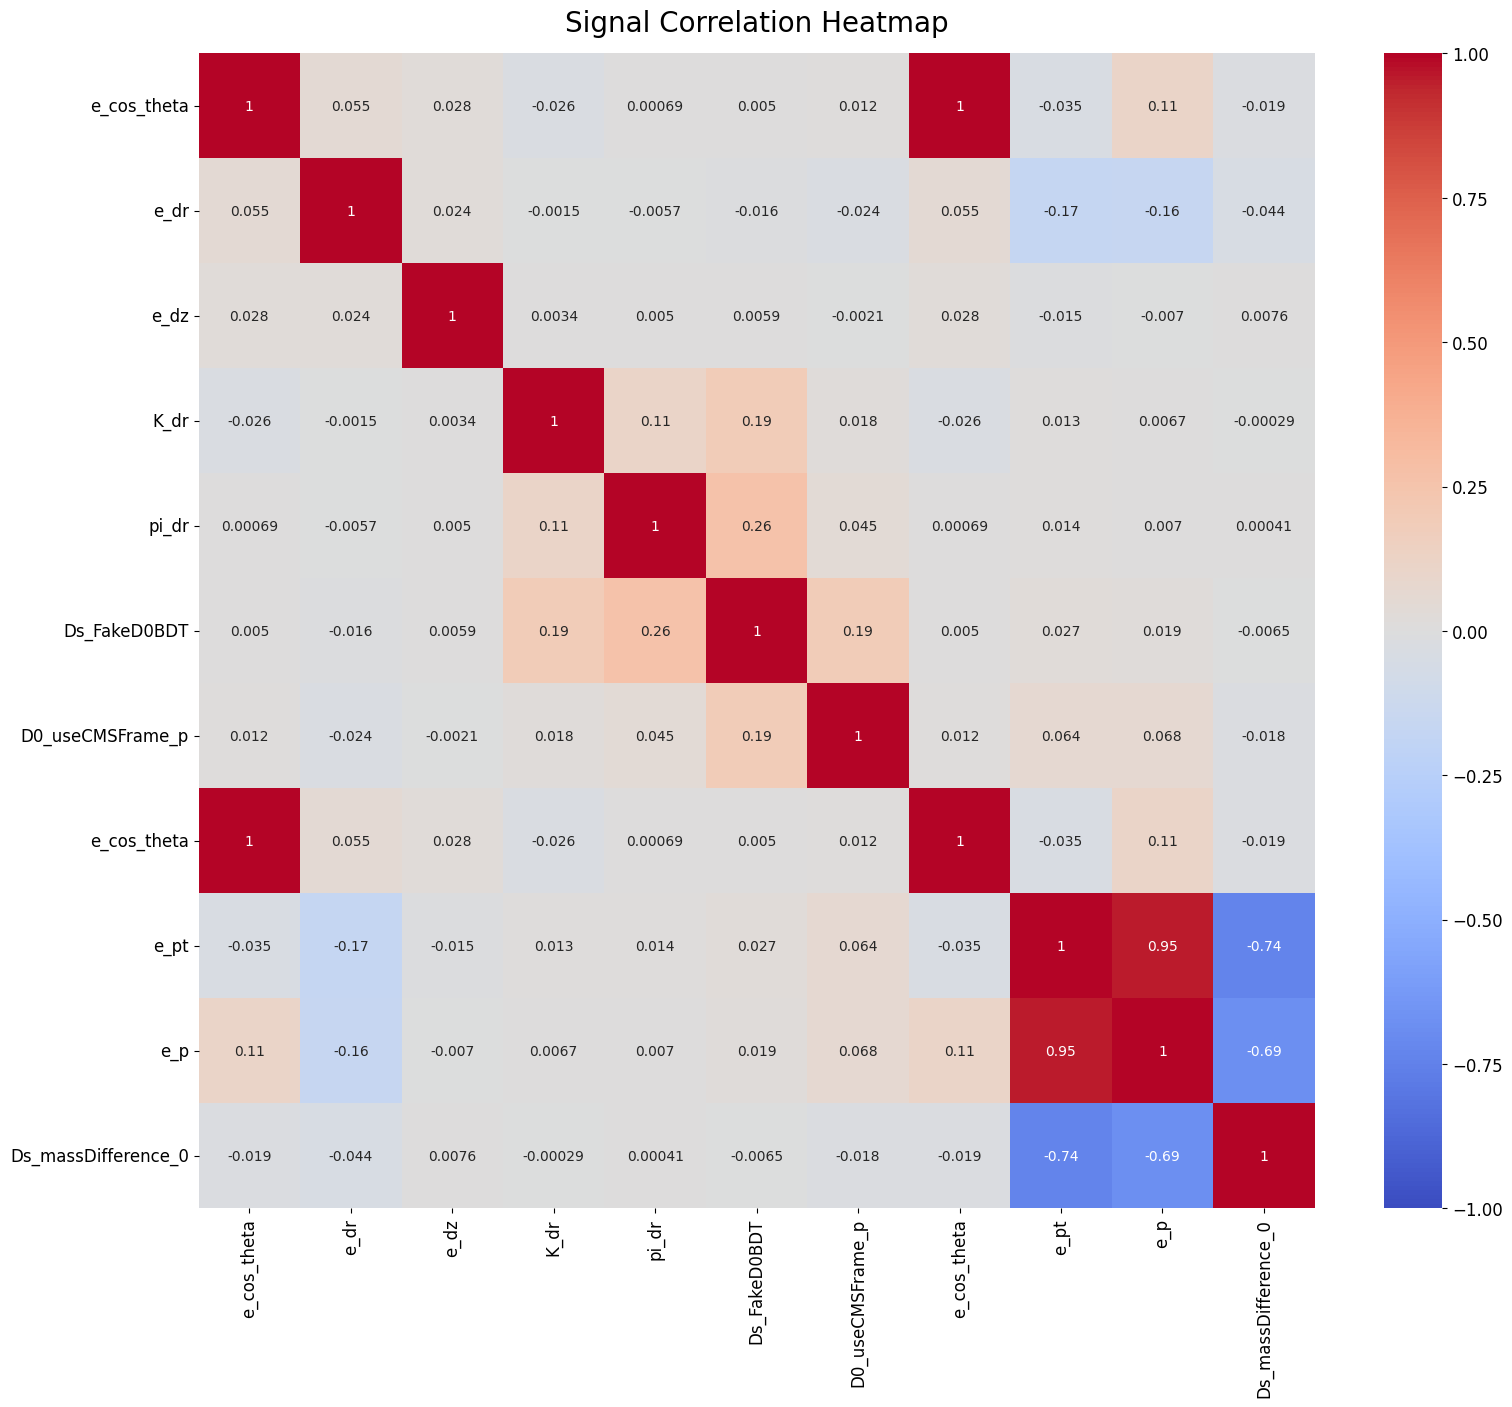

In [96]:
plt.figure(figsize=(18, 15))

heatmap = sns.heatmap(DataFrames["Signal"][DataFrames["Signal"]["Ds_isSignal"]==1][Variables+["e_cos_theta","e_pt","e_p",'Ds_massDifference_0']].corr(), annot=True, cmap="coolwarm",vmin=-1, vmax=1)

heatmap.set_title('Signal Correlation Heatmap', fontdict={'fontsize':20}, pad=16)

Text(0.5, 1.0, 'Background Correlation Heatmap')

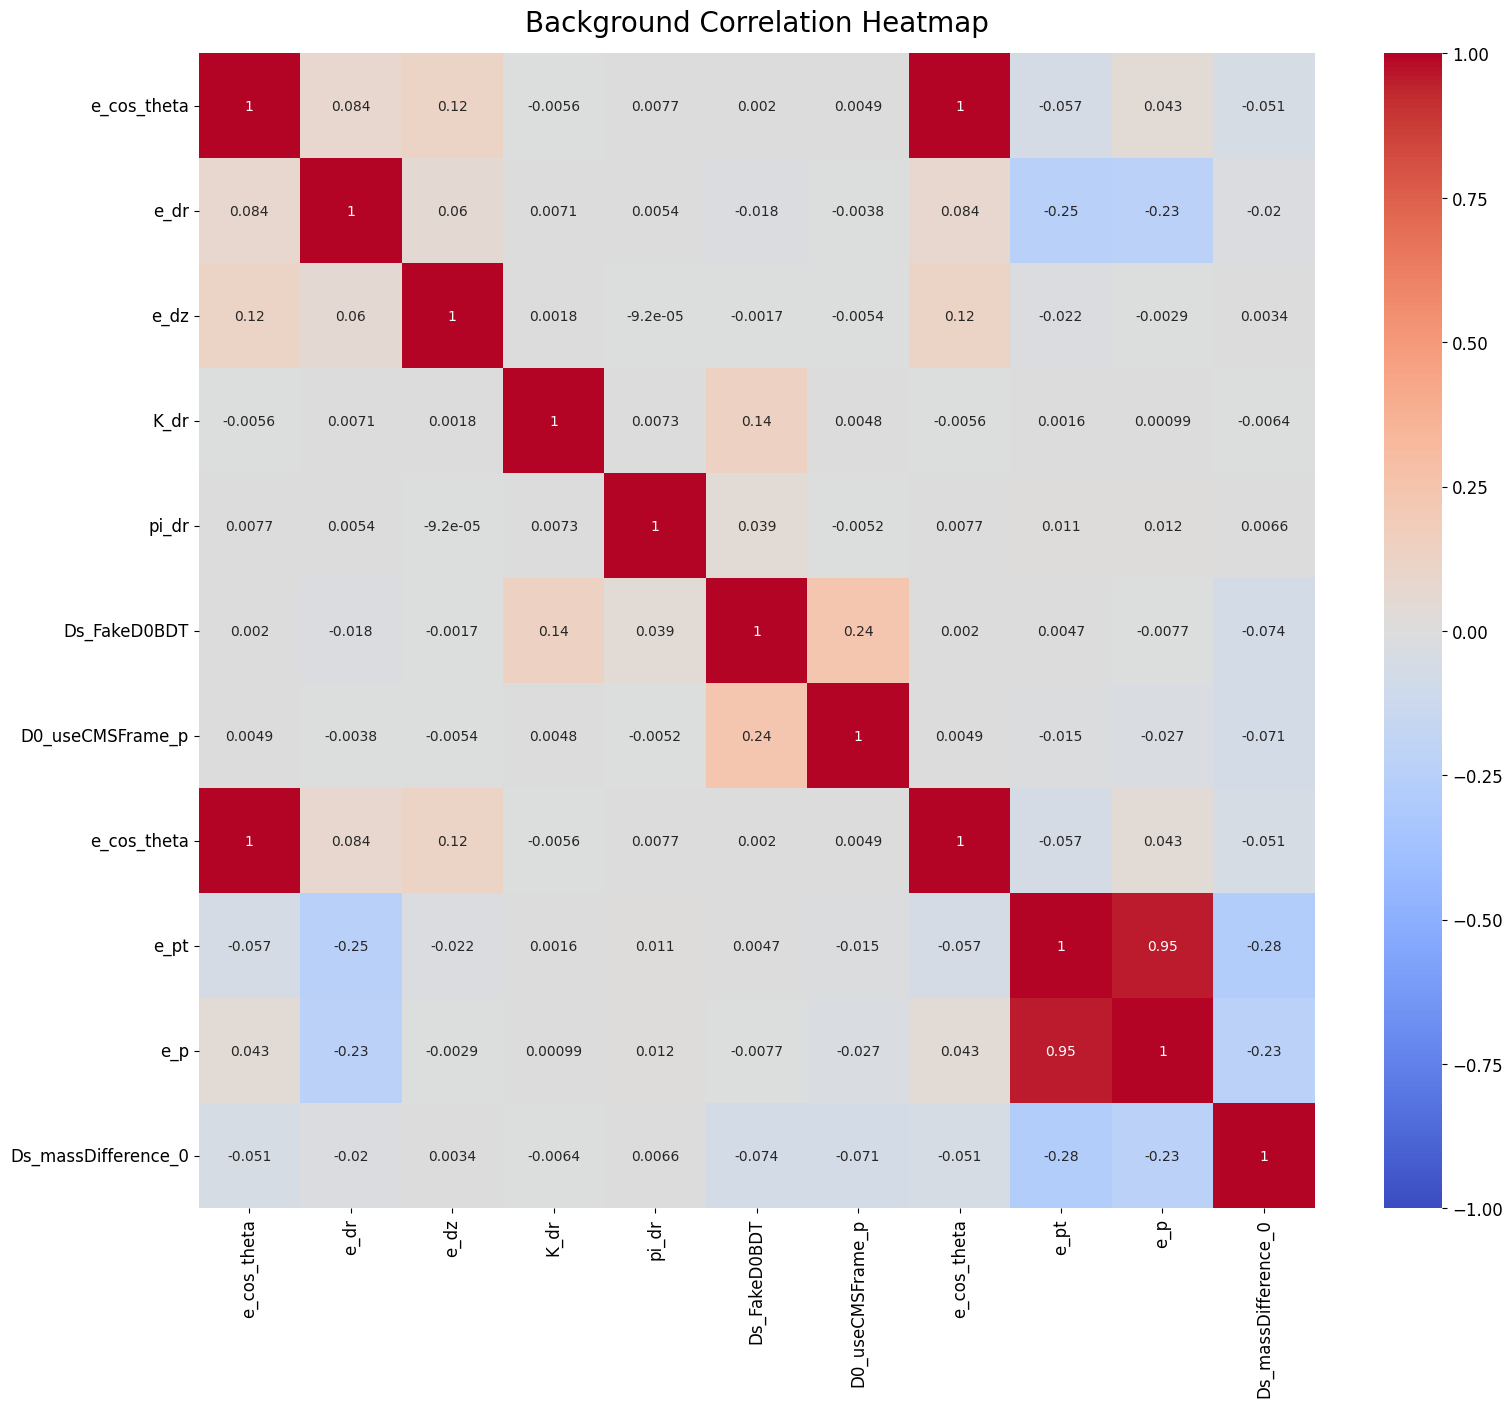

In [97]:
plt.figure(figsize=(18, 15))

heatmap = sns.heatmap(DataFrames["All"][Variables+["e_cos_theta","e_pt","e_p",'Ds_massDifference_0']].corr(), annot=True, cmap="coolwarm",vmin=-1, vmax=1)

heatmap.set_title('Background Correlation Heatmap', fontdict={'fontsize':20}, pad=16)

In [98]:
# import matplotlib.pyplot as plt

# # === Settings ===
# Stacked = False
# Density = True
# Bins = 50
# Range = [0.0, 0.25]
# perBin = ((Range[1] - Range[0]) / Bins) * 1000
# print("Width Per Bin: {:.2f} MeV".format(perBin))

# # === Variables ===
# plot_var = 'Ds_massDifference_0'
# pdg_var = 'Ds_mcPDG'
# cut_var = "Ds_diff_D0pi"
# BS = -1

# # === Control sample: reversed PID ===
# df_ctrl = DataFrames["All_ReverseID"]
# ctrl_mask = (
#     (abs(df_ctrl[pdg_var]) == 413) &
#     (df_ctrl["e_electronID"] < 0.5)
# )
# ctrl_dstar_plus = df_ctrl.loc[ctrl_mask, plot_var].to_numpy()

# # === Generic MC sample ===
# df_gen = DataFrames["All_ReverseID"]
# gen_mask = (
#     (df_gen["e_electronID"] >= 0.5) &
#     (abs(df_gen[pdg_var]) == 413)
# )
# gen_dstar_plus = df_gen.loc[gen_mask, plot_var].to_numpy()

# # === Plot ===
# plt.hist([ctrl_dstar_plus, gen_dstar_plus],
#          label=["Inverted PID", "Signal Selection"],
#          color=["#2E2E2E", "#4C6EB1"],
#          density=Density,
#          stacked=Stacked,
#          bins=Bins,
#          range=Range,
#          histtype='step',
#          linewidth=2.5)

# plt.title(r"$D^{*+}$ Peak Comparison:" + "\n" +
#           r'$\Delta m_{\pi}(D_s^{+} - D^{0}) \notin [0.144,\; 0.147] \; \mathrm{GeV}/c^{2}$', loc="left")
# plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")
# plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
# plt.ylabel(r'$Norm \; Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
# plt.legend()
# # plt.ylim(0, 35)
# plt.show()

## Data Preprocessing

In [99]:
# #  Organise data ready for the machine learning model

# # for sklearn data are usually organised
# # into one 2D array of shape (n_samples x n_features)
# # containing all the data and one array of categories
# # of length n_samples

# all_MC = []  # define empty list that will contain all features for the MC
# for s in GenEvents:  # loop over the different samples
#     if s != "data":  # only MC should pass this
#         all_MC.append(
#             DataFrames[s][Variables]
#         )  # append the MC dataframe to the list containing all MC features
# X = np.concatenate(
#     all_MC
# )  # concatenate the list of MC dataframes into a single 2D array of features, called X

# all_y = (
#     []
# )  # define empty list that will contain labels whether an event in signal or background
# for s in GenEvents:  # loop over the different samples
#     if s != "data":  # only MC should pass this
#         if "Signal" in s:  # only signal MC should pass this
#             all_y.append(
#                 np.ones(DataFrames[s].shape[0], dtype=np.int32)
#             )  # signal events are labelled with 1
#         else:  # only background MC should pass this
#             all_y.append(
#                 np.zeros(DataFrames[s].shape[0], dtype=np.int32)
#             )  # background events are labelled 0
# y = np.concatenate(
#     all_y
# )  # concatenate the list of labels into a single 1D array of labels, called y

In [100]:
# === Organize data for ML: features (X) and labels (y) ===

all_MC = []  # list of all MC feature arrays
all_y = []   # list of all MC label arrays

for s in GenEvents:
    if s == "data":
        continue  # skip data

    df = DataFrames[s]

    if "Signal" in s:
        # Use only true signal (Ds_isSignal == 1)
        # true_signal = df
        true_signal = df[df["Ds_isSignal"]==1]
        all_MC.append(true_signal[Variables])
        all_y.append(np.ones(true_signal.shape[0], dtype=np.int32))
    else:
        # All background MC
        all_MC.append(df[Variables])
        all_y.append(np.zeros(df.shape[0], dtype=np.int32))

# Concatenate into final training arrays
X = np.concatenate(all_MC)
y = np.concatenate(all_y)

#splitting with  Holdout method for eval_set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    # stratify=y
                                                    )

## Model Training

In [101]:
weights = compute_sample_weight('balanced', y_train)

# Create EarlyStopping callback
early_stop = xgboost.callback.EarlyStopping(
    rounds=10,
    metric_name='rmse',
    data_name="validation_0",
    save_best=True,
)

In [102]:
eval_set = [(X_test, y_test)]
bdt = XGBClassifier(objective="binary:logistic",
                    eval_metric="logloss",
                    # early_stopping_rounds=10,
                    # scale_pos_weight=pos_class_weight,
                #     scale_pos_weight=scale,
                    max_delta_step=1,
                    random_state=42,
                    n_estimators=100)

bdt.fit(X_train, y_train, 
        eval_set=[(X_train, y_train),(X_test, y_test)], 
        sample_weight=weights,
        verbose=0) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

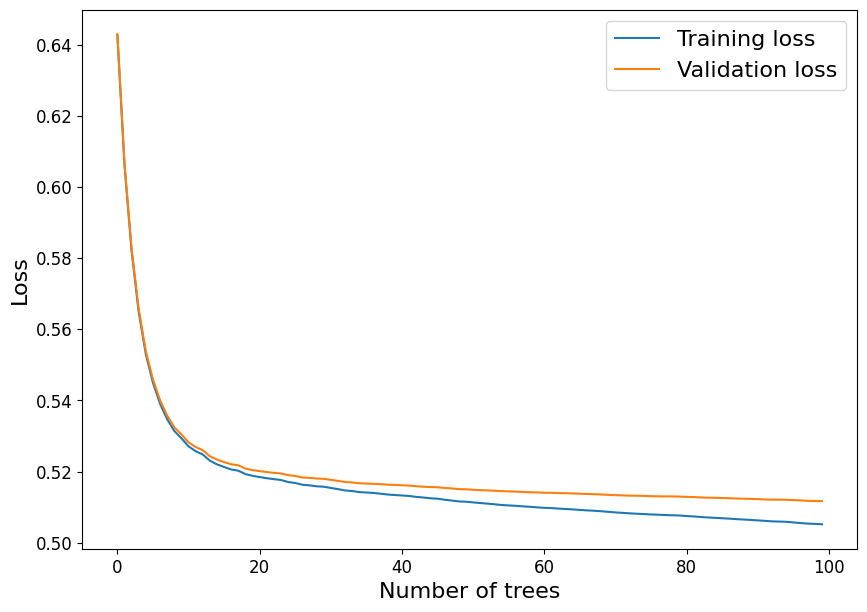

In [103]:
# loss curve of xgboost
results = bdt.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

## Parameter Optimization

This optimization is pulling too much resources and ending the connection

In [104]:
param_dist = {
    "learning_rate": uniform(0.01, 0.2),        # e.g., 0.01 to 0.21
    "max_depth": randint(1, 5),                 # 1 to 4
    "n_estimators": randint(100, 201),          # 100 to 200
    "reg_lambda": randint(1, 5),
    "gamma": randint(0, 4),
    "subsample": uniform(0.5, 0.5),             # 0.5 to 1.0
    "min_child_weight": randint(1, 6),
    "colsample_bytree": uniform(0.3, 0.7)
}

random_search = RandomizedSearchCV(
    bdt,
    param_distributions=param_dist,
    n_iter=50,  # Try only 50 random combos (you can adjust)
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# After running RandomizedSearchCV:
random_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], sample_weight=weights, verbose=0)

# Extract best parameters and apply them to the base model
xgbm_final = bdt.set_params(**random_search.best_params_, random_state=17).fit(X_train, y_train, sample_weight=weights)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [105]:
# cv_results = cross_validate(xgbm_final, X, y, cv=10,
#                             scoring=["f1"],return_train_score=True)

# print(cv_results['train_f1'].mean())
# print(cv_results['test_f1'].mean())

In [106]:
print("Best parameters found by RandomizedSearchCV:")
for param, value in random_search.best_params_.items():
    print(f"{param:20s}: {value}")

Best parameters found by RandomizedSearchCV:
colsample_bytree    : 0.9766583733305687
gamma               : 2
learning_rate       : 0.20606631674320916
max_depth           : 4
min_child_weight    : 5
n_estimators        : 184
reg_lambda          : 4
subsample           : 0.9255683357584285


In [107]:
# xgbm_final = bdt

## Feature Importance

In [108]:
# Get feature importance scores
print(xgbm_final.feature_importances_)

[0.04057035 0.12228805 0.08825038 0.09215668 0.08065422 0.56543386
 0.01064651]


In [109]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features})
    plt.figure(figsize=(16, 8))
#     sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

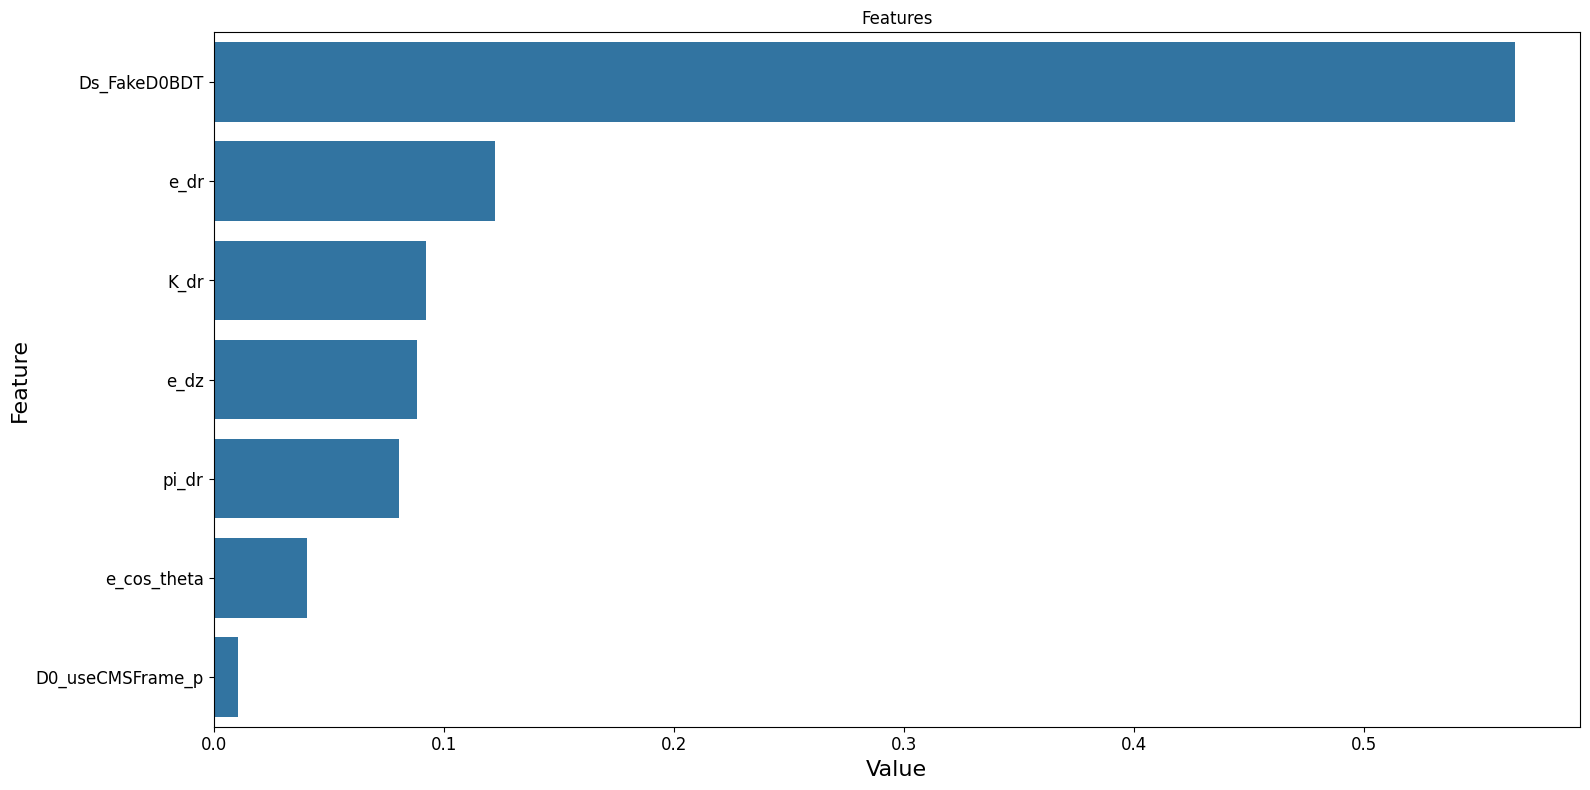

In [110]:
plot_importance(xgbm_final, features)
# When the feature importance graph is observed, 
# it is seen that the variables other than a02 and a01 are important for the xgboost model.

## Overfitting Check

In [111]:
from scipy import stats
def get_pulls(counts,errors,pdf):
    pull = (-pdf + counts) / errors
    return pull

In [112]:
def compare_train_test(clf, X_train, y_train, X_test, y_test):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        if hasattr(clf, "predict_proba"): # if predict_proba function exists
            d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
            d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
        else: # predict_proba function doesn't exist
            X_tensor = torch.as_tensor(X, dtype=torch.float) # make tensor from X_test_scaled
            y_tensor = torch.as_tensor(y, dtype=torch.long) # make tensor from y_test
            X_var, y_var = Variable(X_tensor), Variable(y_tensor) # make variables from tensors
            d1 = clf(X_var[y_var<0.5])[1][:, 1].cpu().detach().numpy() # background
            d2 = clf(X_var[y_var>0.5])[1][:, 1].cpu().detach().numpy() # signal
        decisions += [d1, d2] # add to list of classifier decision

    #pd.set_option('max_columns', None)
#     %config InlineBackend.figure_format = 'retina'
    # plt.style.use('belle2')
    lw=3

    fig,axs=plt.subplots(3,1,figsize=(10,10),gridspec_kw={'height_ratios':[1,0.2,0.2]})

    bins = 50
    bin_edges = np.linspace(0,1,bins)
    
    test_bkg_count_weight=bins/len(decisions[2])
    test_sig_count_weight=bins/len(decisions[3])
    test_bkg_counts,test_bkg_bins = np.histogram(decisions[2],bins=bins,range=(0,1))
    test_sig_counts,test_sig_bins = np.histogram(decisions[3],bins=bins,range=(0,1))

    train_bkg_counts,train_bkg_bins,_etc=axs[0].hist(decisions[0],color = 'tab:blue',
            histtype='step',bins=bins,density=True,range=(0,1),linewidth=lw,label='Train Background')
    train_sig_counts,train_sig_bins,_etc=axs[0].hist(decisions[1],color = 'tab:red',
            histtype='step',bins=bins,density=True,range=(0,1),linewidth=lw,label=r'Train Signal')
    axs[0].hist(decisions[0],color = 'tab:blue',
            histtype='stepfilled',alpha=0.4,bins=bins,density=True,range=(0,1))
    axs[0].hist(decisions[1],color = 'tab:red',
            histtype='stepfilled',alpha=0.4,bins=bins,density=True,range=(0,1))
    bin_width=test_bkg_bins[1]-test_bkg_bins[0]
    bin_centers=[el+(bin_width/2) for el in test_bkg_bins[:-1]]

    axs[0].errorbar(bin_centers,test_bkg_count_weight*test_bkg_counts,
                yerr=test_bkg_count_weight*np.sqrt(test_bkg_counts),label='Test Background',color='tab:blue',
                marker='o',linewidth=lw,ls='')
    axs[0].errorbar(bin_centers,test_sig_count_weight*test_sig_counts,
                yerr=test_sig_count_weight*np.sqrt(test_sig_counts),label='Test Signal',color='tab:red',
                marker='o',linewidth=lw,ls='')
    axs[0].set_title(r'$D_{s}^{+} \rightarrow D^{0} e^{+} \nu_{e}$',loc='left')
    axs[0].set_xlim(0,1)
    axs[0].set_ylim(0)
    axs[0].set_ylabel('Event Density')

    x= decisions[1]
    y=  decisions[3]
    ks_p_value_sig = ks_2samp(x, y)[1]

    x= decisions[0]
    y= decisions[2]
    ks_p_value_bkg = ks_2samp(x, y)[1]

    leg=axs[0].legend(loc='upper center',title=f"Sig K-S test score: {ks_p_value_sig:0.3f}"+
                      "\n"+f"Bkg K-S test score: {ks_p_value_bkg:0.3f}")
    leg._legend_box.align = "left"  

    pulls=get_pulls(test_bkg_count_weight*test_bkg_counts,test_bkg_count_weight*np.sqrt(test_bkg_counts),np.array(train_bkg_counts))
    axs[1].bar(bin_centers,pulls,width=bin_width)
    axs[1].set_xlim(0,1)
    axs[1].set_ylabel('Pulls')
    axs[1].set_ylim(-5,5)

    pulls=get_pulls(test_sig_count_weight*test_sig_counts,test_sig_count_weight*np.sqrt(test_sig_counts),np.array(train_sig_counts))
    axs[2].bar(bin_centers,pulls,width=bin_width,color='tab:red')
    axs[2].set_xlim(0,1)
    axs[2].set_ylabel('Pulls')
    axs[2].set_ylim(-5,5)
    axs[2].set_xlabel(r'BDT output')

    return decisions

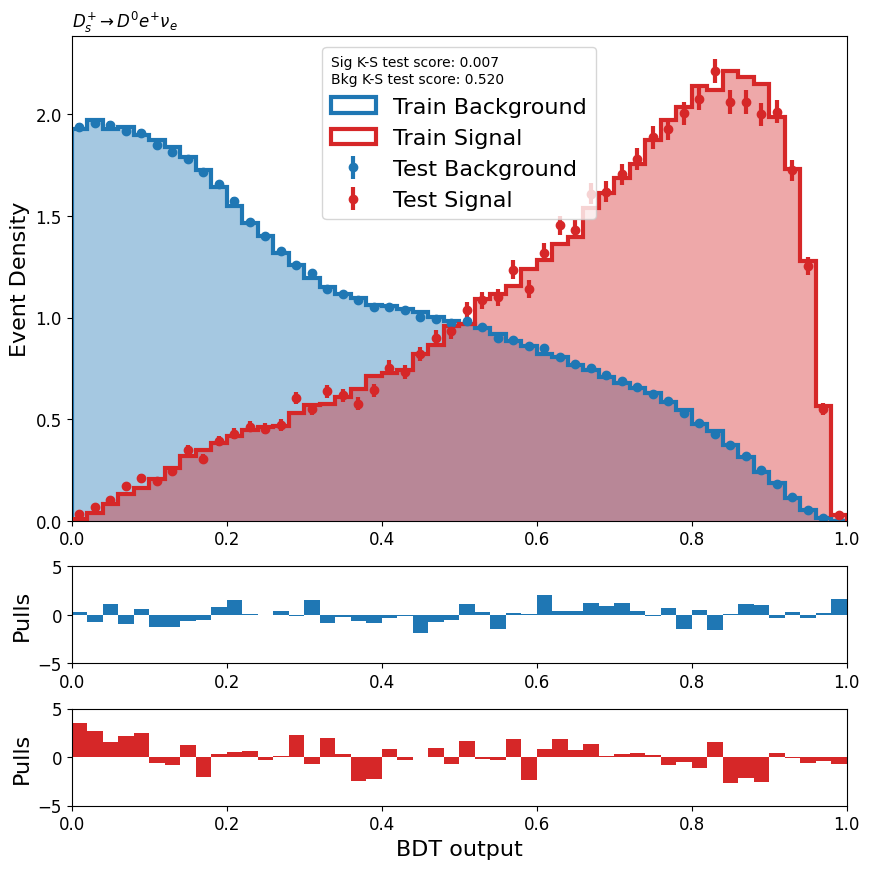

In [113]:
decisions = compare_train_test(xgbm_final, X_train, y_train, X_test, y_test)

## Model Check

### Basf2 ROC

In [114]:
# # compute ROC 
# sig_train=decisions[1]
# sig_test=decisions[3]
# bkg_train=decisions[0]
# bkg_test=decisions[2]

# bdt_cuts=np.linspace(0,1,100)
# sig_efficiency_train=[]
# bkg_rejection_train=[]
# den_sig_train=len(sig_train)
# den_bkg_train=len(bkg_train)

# sig_efficiency_test=[]
# bkg_rejection_test=[]
# den_sig_test=len(sig_test)
# den_bkg_test=len(bkg_test)


# for cut in bdt_cuts:
#     num_sig_train=len([el for el in sig_train if el>cut])
#     num_bkg_train=len([el for el in bkg_train if el>cut])
#     num_sig_test=len([el for el in sig_test if el>cut])
#     num_bkg_test=len([el for el in bkg_test if el>cut])
    
#     sig_efficiency_test.append(num_sig_test/den_sig_test)
#     bkg_rejection_test.append(1-(num_bkg_test/den_bkg_test))
#     sig_efficiency_train.append(num_sig_train/den_sig_train)
#     bkg_rejection_train.append(1-(num_bkg_train/den_bkg_train))

# fig,axs=plt.subplots(1,1,figsize=(8,6))
# lw=2
# axs.plot([1, 0], [0, 1], color='grey', linestyle='--')
# axs.plot(bkg_rejection_train,sig_efficiency_train,color='tab:blue',marker='',linewidth=lw,label='Train')
# axs.plot(bkg_rejection_test,sig_efficiency_test,color='tab:red',marker='',linewidth=lw,ls='--',label='Test')
# axs.set_title(r'$D_{s}^{+} \rightarrow D^{0} e^{+} \nu_{e}$',loc='left')

# axs.set_ylim(0,1.05)
# axs.set_xlim(0,1.05)
# axs.legend(loc='lower left')
# axs.set_xlabel('Background rejection')
# axs.set_ylabel('Signal efficiency')
# plt.tight_layout()

# plt.show()

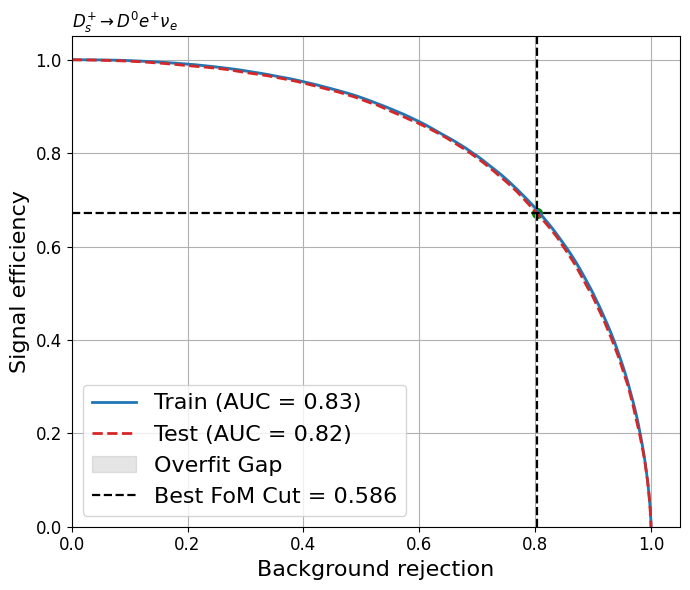

In [115]:
y_score_test = xgbm_final.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_score_test)
area_test = auc(fpr_test, tpr_test)

y_score_train = xgbm_final.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_score_train)
area_train = auc(fpr_train, tpr_train)

# Get classifier scores (probabilities for class 1)
train_scores = xgbm_final.predict_proba(X_train)[:, 1]
test_scores  = xgbm_final.predict_proba(X_test)[:, 1]

# Use y_train and y_test to separate signal/background
sig_train = train_scores[y_train == 1]
bkg_train = train_scores[y_train == 0]
sig_test  = test_scores[y_test == 1]
bkg_test  = test_scores[y_test == 0]

# Optionally, group them into one list like this:
decisions = [bkg_train, sig_train, bkg_test, sig_test]

bdt_cuts = np.linspace(0, 1, 100)

sig_eff_train = []
bkg_rej_train = []
sig_eff_test = []
bkg_rej_test = []
fom_vals = []

for cut in bdt_cuts:
    num_sig_train = np.sum(sig_train > cut)
    num_bkg_train = np.sum(bkg_train > cut)
    num_sig_test = np.sum(sig_test > cut)
    num_bkg_test = np.sum(bkg_test > cut)

    # FoM calculation
    fom = num_sig_test / np.sqrt(num_sig_test + num_bkg_test) if (num_sig_test + num_bkg_test) > 0 else 0
    fom_vals.append(fom)

    sig_eff_train.append(num_sig_train / len(sig_train))
    bkg_rej_train.append(1 - (num_bkg_train / len(bkg_train)))
    sig_eff_test.append(num_sig_test / len(sig_test))
    bkg_rej_test.append(1 - (num_bkg_test / len(bkg_test)))

# Find optimal FoM point
fom_vals = np.array(fom_vals)
best_idx = np.argmax(fom_vals)
best_cut = bdt_cuts[best_idx]

# Plot
fig, axs = plt.subplots(1, 1, figsize=(7, 6))
lw = 2

# axs.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random')
axs.plot(bkg_rej_train, sig_eff_train, color='tab:blue', linewidth=lw, label=f'Train (AUC = {area_train:.2f})')
axs.plot(bkg_rej_test, sig_eff_test, color='tab:red', linestyle='--', linewidth=lw, label=f'Test (AUC = {area_test:.2f})')

# ① Shade the overfit gap
axs.fill_between(bkg_rej_test,
                 sig_eff_train,
                 sig_eff_test,
                 where=(np.array(sig_eff_train) > np.array(sig_eff_test)),
                 color='gray', alpha=0.2, label='Overfit Gap')

# ② Mark the optimal cut point (from test curve)
axs.axhline(sig_eff_test[best_idx], color='black', ls='--', linewidth=1.6,
            label=f'Best FoM Cut = {best_cut:.3f}')
axs.axvline(bkg_rej_test[best_idx], color='black', ls='--', linewidth=1.6)
axs.scatter(bkg_rej_test[best_idx], sig_eff_test[best_idx], color='green', s=50)

# Axis labels and formatting
axs.set_title(r'$D_{s}^{+} \rightarrow D^{0} e^{+} \nu_{e}$', loc='left')
axs.set_ylim(0, 1.05)
axs.set_xlim(0, 1.05)
axs.set_xlabel('Background rejection')
axs.set_ylabel('Signal efficiency')
axs.legend(loc='lower left')
axs.grid(True)
plt.tight_layout()
plt.show()


### Machine Learing ROC

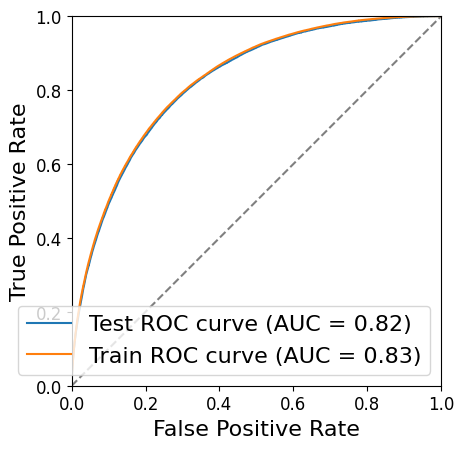

In [116]:
y_score_test = xgbm_final.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_score_test)
area_test = auc(fpr_test, tpr_test)

y_score_train = xgbm_final.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_score_train)
area_train = auc(fpr_train, tpr_train)

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {area_test:.2f})')
plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (AUC = {area_train:.2f})')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
# We can make the plot look nicer by forcing the grid to be square
plt.gca().set_aspect('equal', adjustable='box')

In [117]:
# Make predictions on the test set
y_pred_proba = xgbm_final.predict_proba(X_test)[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC AUC Score: {roc_auc:.2f}")

ROC AUC Score: 0.82


### Other Checks

Check if XGBoost Is Overfitting

In [118]:
# Predict on training and validation sets
train_preds = xgbm_final.predict(X_train)
val_preds = xgbm_final.predict(X_test)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, train_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Check for large difference between train and validation accuracy
if train_accuracy - val_accuracy > 0.1:
    print("Warning: The model may be overfitting!")

Training Accuracy: 0.7302
Validation Accuracy: 0.7284


Check if XGBoost Is Underfitting

In [119]:
# Predict on training and validation sets
train_preds = xgbm_final.predict(X_train)
val_preds = xgbm_final.predict(X_test)

# Calculate MSE for training and validation sets
train_mse = mean_squared_error(y_train, train_preds)
val_mse = mean_squared_error(y_test, val_preds)

print(f"Training MSE: {train_mse:.4f}")
print(f"Validation MSE: {val_mse:.4f}")

# Check if both training and validation MSE are high
if train_mse > 100 and val_mse > 100:
    print("Warning: The model may be underfitting!")
    print("Consider increasing model complexity by adding more estimators, reducing learning rate, or adjusting other hyperparameters.")

Training MSE: 0.2698
Validation MSE: 0.2716


## BDT Cut Optimization

In [120]:
# Apply BDT to all DataFrames that contain the required Variables
for key in DataFrames.keys():
    df = DataFrames[key]
    
    # Check: make sure all input BDT variables exist in this DataFrame
    if all(var in df.columns for var in Variables):
        # Apply BDT and store the result
        DataFrames[key]["Ds_BkgBDT"] = xgbm_final.predict_proba(df[Variables])[:, 1].astype(np.float32)

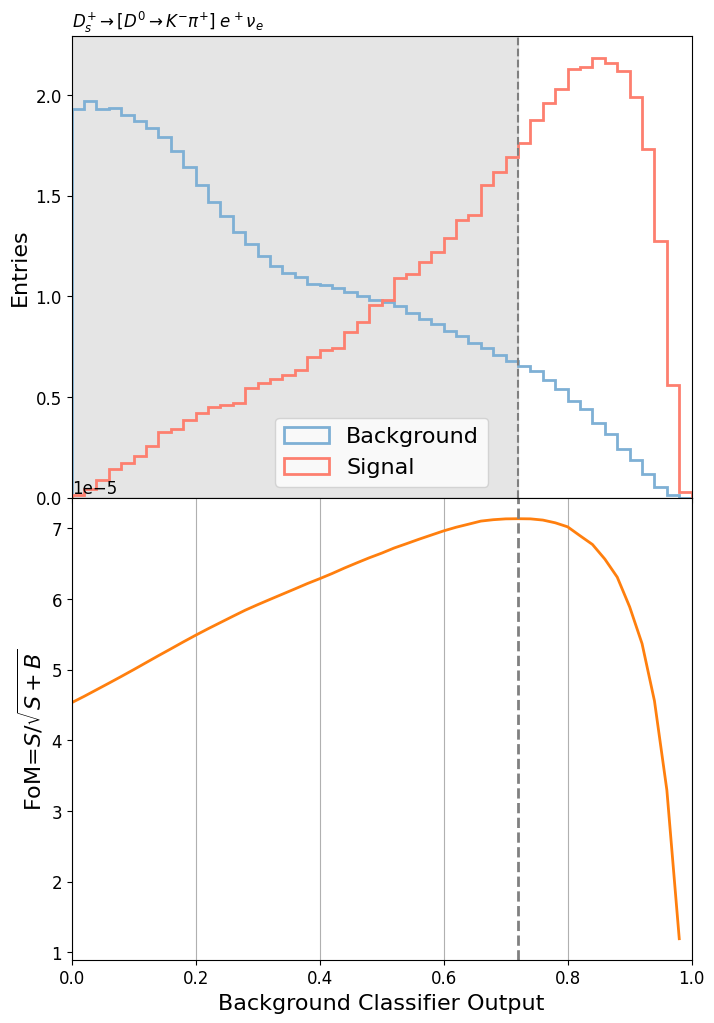

FoM maximized at 0.720
Best cut is: 0.720


In [121]:
from Functions import optimize_cut, plot_save

cut = optimize_cut(
    df_sig=DataFrames["Signal"],                  # used for plotting signal vs background
    df_bkg=DataFrames["All"],
    Signal=DataFrames["Signal"],                  # used for FoM numerator (truth-matched signal)
    Background=DataFrames["All"],                 # used for FoM denominator (everything else)
    var="Ds_BkgBDT",                              # new classifier variable
    FoM="Ds_BkgBDT",                              # same as var here
    xlabel="Background Classifier Output",
    Bins=50,
    Range=[0, 1],
    varmin=0,
    varmax=0.98,
    select="right",                               # keep events with higher classifier output
    Width=False,
    query_signal="Ds_isSignal == 1"
)

print(f"Best cut is: {cut:.3f}")

# Plots

In [122]:
plt.style.use('default')
plt.rcParams.update({
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 16,
    "figure.titlesize": 20
})

Suggested Background Break-up

Width Per Bin: 16.00 MeV


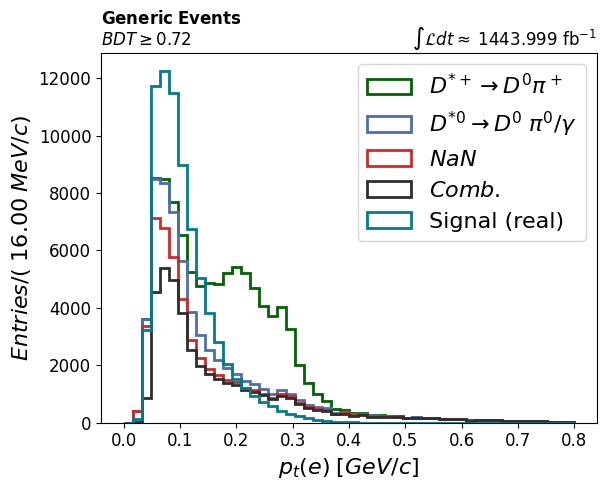

Width Per Bin: 18.38 MeV


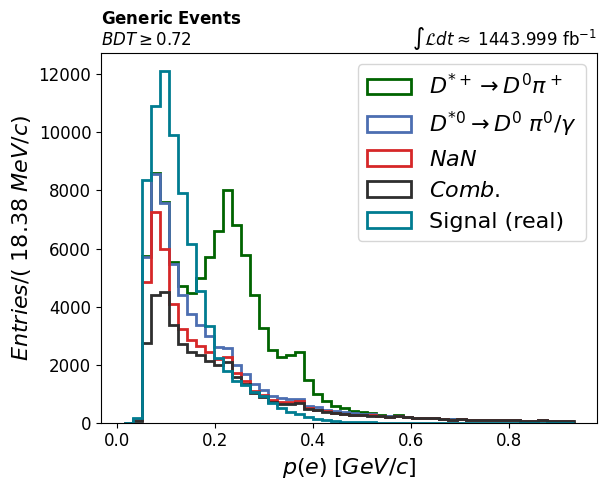


Real signal percent decrease vs minimal e_pt cut (baseline = your selection, no momentum cut)
cut[GeV]         kept       lost      lost[%]
0.00            74561          0        0.00%
0.05            70315       4246        5.69%
0.10            33246      41315       55.41%
0.15            13455      61106       81.95%
0.20             5495      69066       92.63%
0.25             2163      72398       97.10%
0.30              700      73861       99.06%

Real signal percent decrease vs minimal e_p cut (baseline = your selection, no momentum cut)
cut[GeV]         kept       lost      lost[%]
0.00            74561          0        0.00%
0.10            46755      27806       37.29%
0.20            10885      63676       85.40%
0.30             2803      71758       96.24%
0.40              405      74156       99.46%
0.50               45      74516       99.94%
0.60                9      74552       99.99%
0.80                0      74561      100.00%
1.00                0      74

In [123]:
# === keep your existing imports and DataFrames in scope ===
import numpy as np
import matplotlib.pyplot as plt
# from Functions import optimize_cut  # not used here since you said FoM code wasn't needed

# --- your original-style config (left intact) ---
Stacked = True
Density = False
Bins = 50
BS = 0.72
Samples = "All"

label1= r'$Comb.$'
label2= r'$NaN$'
label3= r'$D^{*0} \rightarrow D^{0} \; \pi^0 / \gamma$'
label4= r'$D^{*+} \rightarrow D^{0} \pi^+$'
labels=[label1,label2,label3,label4]
colors=[
    "#2E2E2E",  # Comb. (dark gray-black)
    "#D62728",  # NaN (dark red)
    "#4C6EB1",  # D*0 (muted blue)
    "#006400",  # D*+ → D0π+ (deep green)
]
signal_color = "#007C91"  # overlay for real signal

# --- baseline selections (identical to your df_all) ---
df_all = DataFrames["All"][
    (DataFrames["All"]["Ds_BkgBDT"] >= BS) &
    (DataFrames["All"]["Ds_gammaveto_M_Correction"] >= 0.1) &
    (DataFrames["All"]["Ds_Dstarplus_massDifference_Correction"] >= 0.16)
].copy()

df_sig = DataFrames["Signal"][
    (DataFrames["Signal"]["Ds_isSignal"] == 1) &
    (DataFrames["Signal"]["Ds_BkgBDT"] >= BS) &
    (DataFrames["Signal"]["Ds_gammaveto_M_Correction"] >= 0.1) &
    (DataFrames["Signal"]["Ds_Dstarplus_massDifference_Correction"] >= 0.16)
].copy()

# --- helper: build stacked background series for a var ---
def stacked_series(df, var):
    return [
        df[(~df["Ds_mcPDG"].isna()) & (abs(df["Ds_mcPDG"]) != 413) & (abs(df["Ds_mcPDG"]) != 423)][var],
        df[(df["Ds_mcPDG"].isna())][var],
        df[abs(df["Ds_mcPDG"]) == 423][var],
        df[abs(df["Ds_mcPDG"]) == 413][var],
    ]

# --- helper: plot in your exact style and overlay real signal ---
def make_plot(var, Range, xlabel_text):
    perBin = ((Range[1] - Range[0]) / Bins) * 1000.0
    print("Width Per Bin: {width:.2f} MeV".format(width=perBin))

    data_bg = stacked_series(df_all, var)
    plt.hist(
        data_bg,
        color=colors,
        label=labels,
        density=Density,
        stacked=Stacked,
        bins=Bins,
        alpha=1,
        histtype='step',
        linewidth=2,
        range=Range
    )

    # overlay real signal as its own step histogram
    sig_vals = df_sig[var].dropna().to_numpy()
    if sig_vals.size > 0:
        plt.hist(
            sig_vals,
            bins=Bins,
            range=Range,
            histtype='step',
            linewidth=2,
            alpha=1,
            density=Density,
            label="Signal (real)",
            color=signal_color
        )

    # titles and labels
    plt.title(r'$\bf Generic \; Events$' + "\n" + rf"$BDT \geq {BS}$", loc="left")
    plt.title(r'$\int\mathcal{L}dt\approx\;1443.999$ fb$^{-1}$', loc="right")
    plt.ylabel(r'$Entries/(\; {width:.2f}\;MeV/c)$'.format(width=perBin))
    plt.xlabel(xlabel_text)
    plt.legend()
    plt.show()

# --- helper: print percent decrease of real signal vs momentum cut grid ---
def print_signal_loss(var, thresholds, side="right"):
    sig_series = df_sig[var].dropna()
    n0 = int(sig_series.size)
    print(f"\nReal signal percent decrease vs minimal {var} cut (baseline = your selection, no momentum cut)")
    if n0 == 0:
        print("No real signal in baseline. Skipping table.")
        return
    op = (lambda x, thr: x >= thr) if side == "right" else (lambda x, thr: x <= thr)
    print("{:<10s} {:>10s} {:>10s} {:>12s}".format("cut[GeV]", "kept", "lost", "lost[%]"))
    for thr in thresholds:
        n_keep = int(np.count_nonzero(op(sig_series.values, thr)))
        n_lost = n0 - n_keep
        pct_lost = 100.0 * n_lost / n0
        print("{:<10.2f} {:>10d} {:>10d} {:>11.2f}%".format(thr, n_keep, n_lost, pct_lost))

# --- plot 1: e_pt exactly like yours, plus signal overlay ---
make_plot(var="e_pt", Range=[0.0, 0.8], xlabel_text=r'$p_{t}(e)\;[GeV/c]$')

# --- plot 2: e_p in a sensible range (auto from data percentiles); adjust if you want fixed range ---
def autorange(arr, fallback=(0.0, 1.2)):
    x = np.asarray(arr)
    x = x[np.isfinite(x)]
    if x.size < 10:
        return list(fallback)
    lo = float(np.percentile(x, 0.0))
    hi = float(np.percentile(x, 99.5))
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return list(fallback)
    pad = 0.02 * (hi - lo)
    return [max(0.0, lo - pad), hi + pad]

e_p_range = autorange(df_all["e_p"].values, fallback=(0.0, 1.2))
make_plot(var="e_p", Range=e_p_range, xlabel_text=r'$p(e)\;[GeV/c]$')

# --- percent decrease tables for the cuts you care about ---
thr_ept = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
thr_ep  = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.80, 1.00]

print_signal_loss("e_pt", thr_ept, side="right")
print_signal_loss("e_p",  thr_ep,  side="right")

Width Per Bin: 5.00 MeV


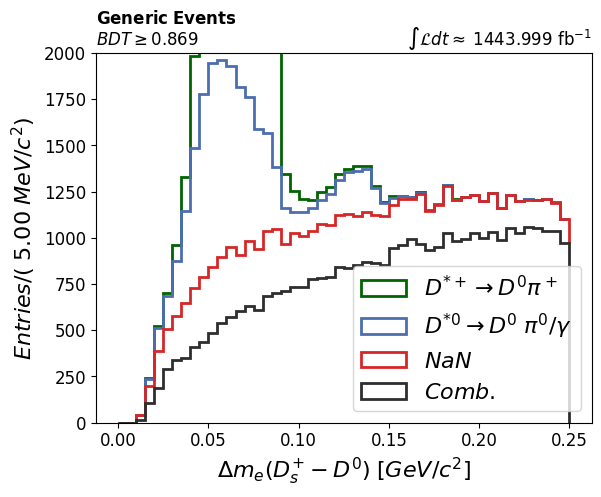

In [124]:
Stacked = True
Density = False
Bins = 50
# var = 'Ds_diff_D0pi'
var = 'Ds_massDifference_0'
# var = 'Ds_M'
Range = [0.0, 0.25]
BS = 0.72
Samples = "All"
perBin = ((Range[1] - Range[0])/Bins)*1000
print("Width Per Bin: {width:.2f} MeV".format(width = perBin))

label1= r'$Comb.$'
label2= r'$NaN$'
label3= r'$D^{*0} \rightarrow D^{0} \; \pi^0 / \gamma$'
label4= r'$D^{*+} \rightarrow D^{0} \pi^+$'

labels=[label1,label2,label3,label4]
colors=[
    "#2E2E2E",  # Comb. (dark gray-black)
    "#D62728",  # NaN (dark red)
    "#4C6EB1",  # D*0 (muted blue)
    "#006400",  # D*+ → D0π+ (deep green)
]
df_all = DataFrames["All"][(DataFrames["All"]["Ds_BkgBDT"]>=BS) &
                           (DataFrames["All"]["Ds_gammaveto_M_Correction"]>=0.1)
                        #    (DataFrames["All"]['e_p']>=0.04) &
                        #    (DataFrames["All"]["Ds_Dstarplus_massDifference_Correction"]>=0.16)
                           ]
data = [
    df_all[(~df_all["Ds_mcPDG"].isna()) & (abs(df_all["Ds_mcPDG"]) != 413) & (abs(df_all["Ds_mcPDG"]) != 423)][var],
    df_all[(df_all["Ds_mcPDG"].isna())][var],
    df_all[abs(df_all["Ds_mcPDG"]) == 423][var],
    df_all[abs(df_all["Ds_mcPDG"]) == 413][var],
]

# factor = 0.7
# plt.hist(DataFrames["Signal"][(DataFrames["Signal"]["Ds_BkgBDT"]>=BS)][var], label="Signal", histtype='step', density=Density, bins=Bins, alpha=1, range=Range, weights=factor*np.ones_like(DataFrames["Signal"][(DataFrames["Signal"]["Ds_BkgBDT"]>=BS)][var]), ls='--', linewidth=1.5)
plt.hist(data, color=colors, label=labels, density=Density, stacked=Stacked, bins=Bins, alpha=1, histtype='step', linewidth=2, range=Range)
# plt.axvspan(Range[0],0.16,color='gray',alpha=0.2)
# plt.axvline(0.16,ls='--',color='gray')

# Title
#--------
# plt.title(r'$\bf Generic \; Events$', loc = "left")
plt.title(r'$\bf Generic \; Events$' + "\n" + r"$BDT \geq 0.869$", loc = "left")
plt.title(r'$\int\mathcal{L}dt\approx\;1443.999$ fb$^{-1}$', loc = "right")
# Label
#-------
plt.ylabel(r'$Entries/(\; {width:.2f}\;MeV/c^2)$'.format(width = perBin))
plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
# plt.yscale("log")
# plt.xscale("log")
plt.ylim(0, 2000)
plt.legend()
plt.show()

Width Per Bin: 5.00 MeV


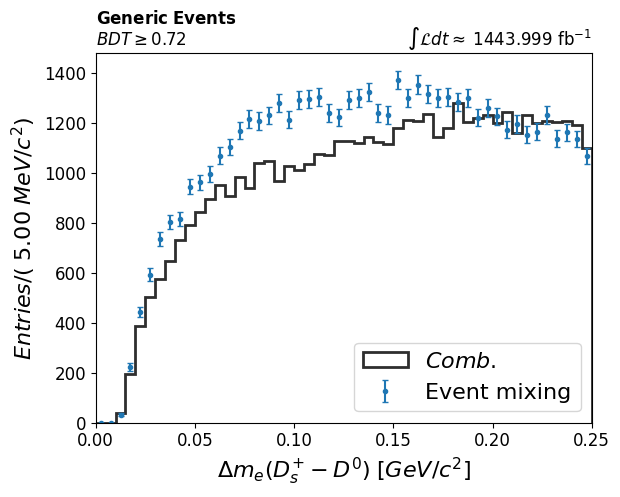

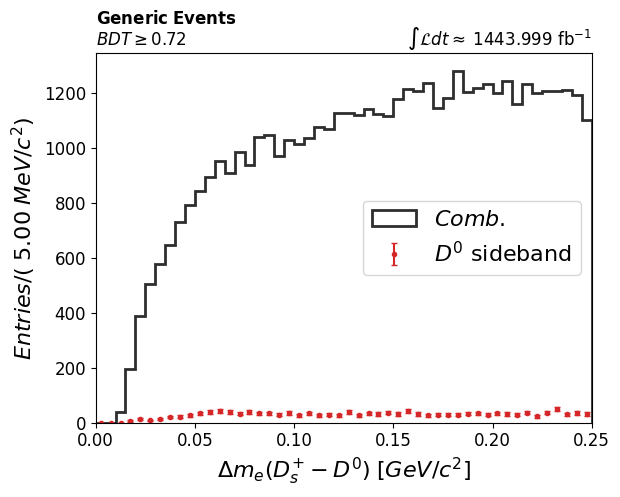

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------
# Config
# -------------------
Bins = 50
Range = [0.0, 0.25]
BS = 0.72
var = 'Ds_massDifference_0'
perBin = ((Range[1] - Range[0]) / Bins) * 1000.0
print("Width Per Bin: {width:.2f} MeV".format(width=perBin))

# Colors
c_orig = "#2E2E2E"   # original Comb. (dark gray)
c_mix  = "#1f77b4"   # event-mixing (blue)
c_sb   = "#d62728"   # D0 sideband sample (red)

# -------------------
# Helper masks
# -------------------
df_all = DataFrames["All"][
    (DataFrames["All"]["Ds_BkgBDT"] >= BS) &
    (DataFrames["All"]["Ds_gammaveto_M_Correction"] >= 0.1)
].copy()

# Original Comb. mask: merge NaN and non-D* categories
mask_comb_orig = (
    df_all["Ds_mcPDG"].isna()
    | ((~df_all["Ds_mcPDG"].isna()) &
       (df_all["Ds_mcPDG"].abs() != 413) &
       (df_all["Ds_mcPDG"].abs() != 423))
)

# Common bins
bins = np.linspace(Range[0], Range[1], Bins + 1)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Original Comb. histogram (no errors needed here)
orig_vals = df_all.loc[mask_comb_orig, var].to_numpy()
orig_counts, _ = np.histogram(orig_vals, bins=bins)

# -------------------
# 1) Event mixing
# -------------------
def compute_delta_m_mix(df):
    """
    Approximate Δm from mixed e + D0 four-vectors:
      Δm_mixed = M(e + D0)_mixed - M(D0)_original
    Replace with your exact Δm function if it differs.
    """
    # Shuffle electrons to break true correlations
    e = df[['e_px', 'e_py', 'e_pz', 'e_E']].sample(frac=1, replace=False, random_state=1337).reset_index(drop=True)
    d0 = df[['D0_px', 'D0_py', 'D0_pz', 'D0_E', 'D0_M']].reset_index(drop=True)

    px = e['e_px'].to_numpy() + d0['D0_px'].to_numpy()
    py = e['e_py'].to_numpy() + d0['D0_py'].to_numpy()
    pz = e['e_pz'].to_numpy() + d0['D0_pz'].to_numpy()
    E  = e['e_E' ].to_numpy() + d0['D0_E' ].to_numpy()

    M2 = np.maximum(E*E - (px*px + py*py + pz*pz), 0.0)
    M_sum = np.sqrt(M2)
    return M_sum - d0['D0_M'].to_numpy()

# Build mixed Δm on the same preselected df_all
dm_mix = compute_delta_m_mix(df_all)
mix_counts, _ = np.histogram(dm_mix, bins=bins)
mix_err = np.sqrt(mix_counts)

# -------------------
# 2) D0 “sideband” sample per your spec
#     You said: use D0_isSignal == 0 and nothing else (keep the same BDT and photon-veto cuts).
# -------------------
df_d0sb = df_all[df_all['D0_isSignal'] == 0]
sb_vals = df_d0sb[var].to_numpy()
sb_counts, _ = np.histogram(sb_vals, bins=bins)
sb_err = np.sqrt(sb_counts)

# -------------------
# Plot A: Original Comb. vs Event mixing
# -------------------
plt.figure()
# Original comb as step line
plt.hist([orig_vals], bins=bins, histtype='step', linewidth=2, color=[c_orig],
         label=[r"$Comb.$"], range=Range, density=False)

# Event-mixing with Poisson errors
plt.errorbar(bin_centers, mix_counts, yerr=mix_err, fmt='o', ms=3, capsize=2, color=c_mix, label="Event mixing")

# Labels and styling
plt.title(r'$\bf Generic\;Events$' + "\n" + fr"$BDT \geq {BS}$", loc="left")
plt.title(r'$\int\mathcal{L}dt\approx\;1443.999$ fb$^{-1}$', loc="right")
plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
plt.ylabel(rf'$Entries/(\; {perBin:.2f}\;MeV/c^2)$')
plt.xlim(Range)
plt.legend()
plt.show()

# -------------------
# Plot B: Original Comb. vs D0 “sideband” sample
# -------------------
plt.figure()
# Original comb as step line
plt.hist([orig_vals], bins=bins, histtype='step', linewidth=2, color=[c_orig],
         label=[r"$Comb.$"], range=Range, density=False)

# D0 sideband with Poisson errors
plt.errorbar(bin_centers, sb_counts, yerr=sb_err, fmt='o', ms=3, capsize=2, color=c_sb, label=r"$D^0$ sideband")

# Labels and styling
plt.title(r'$\bf Generic\;Events$' + "\n" + fr"$BDT \geq {BS}$", loc="left")
plt.title(r'$\int\mathcal{L}dt\approx\;1443.999$ fb$^{-1}$', loc="right")
plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
plt.ylabel(rf'$Entries/(\; {perBin:.2f}\;MeV/c^2)$')
plt.xlim(Range)
plt.legend()
plt.show()

Width Per Bin: 5.00 MeV


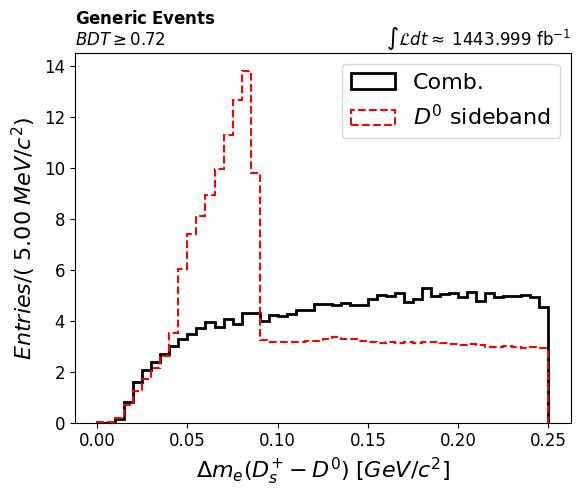

In [126]:
# Same binning, range, and cuts as before
Stacked = False
Density = True  # <-- drop normalization
Bins = 50
var = 'Ds_massDifference_0'
Range = [0.0, 0.25]
BS = 0.72
perBin = ((Range[1] - Range[0])/Bins)*1000
print("Width Per Bin: {width:.2f} MeV".format(width=perBin))

# --- Original comb shape ---
comb_original = DataFrames["All"][
    (DataFrames["All"]["Ds_BkgBDT"] >= BS) &
    (DataFrames["All"]["Ds_gammaveto_M_Correction"] >= 0.1) &
    ((~DataFrames["All"]["Ds_mcPDG"].isna()) &
     (abs(DataFrames["All"]["Ds_mcPDG"]) != 413) &
     (abs(DataFrames["All"]["Ds_mcPDG"]) != 423) |
     (DataFrames["All"]["Ds_mcPDG"].isna()))
][var]

# --- D⁰ sideband ---
d0_sideband = DataFrames["All"][
    # (DataFrames["All"]["Ds_BkgBDT"] >= BS) &
    (DataFrames["All"]["Ds_gammaveto_M_Correction"] >= 0.1) &
    (DataFrames["All"]["Ds_BkgBDT"] <= BS)  # sideband selection
][var]

# Plot
plt.hist(comb_original, bins=Bins, range=Range, histtype='step',
         color='black', linewidth=2, label='Comb.', density=Density)

plt.hist(d0_sideband, bins=Bins, range=Range, histtype='step',
         color='red', linewidth=1.5, linestyle='--', label=r'$D^{0}$ sideband',
         density=Density)

plt.title(r'$\bf Generic \; Events$' + "\n" + rf"$BDT \geq {BS}$", loc="left")
plt.title(r'$\int\mathcal{L}dt\approx\;1443.999$ fb$^{-1}$', loc="right")
plt.ylabel(r'$Entries/(\; {width:.2f}\;MeV/c^2)$'.format(width=perBin))
plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
# plt.ylim(0, 2000)
plt.legend()
plt.show()

In [127]:
Stacked = True
Density = True
Bins = 50
# var = 'Ds_diff_D0pi'
var = 'Ds_massDifference_0'
Range = [0.0, 0.15]
BS = 0.88
Samples = "All"
perBin = ((Range[1] - Range[0])/Bins)*1000
print("Width Per Bin: {width:.2f} MeV".format(width = perBin))

label1= r'$Comb.$'
label2= r'$NaN$'
label3= r'$D^{*0} \rightarrow D^{0} \; \pi^0 / \gamma$'
label4= r'$D^{*+} \rightarrow D^{0} \pi^+$'

labels=[label1,label2,label3,label4]
colors=[
    "#2E2E2E",  # Comb. (dark gray-black)
    "#D62728",  # NaN (dark red)
    "#4C6EB1",  # D*0 (muted blue)
    "#006400",  # D*+ → D0π+ (deep green)
]
df_all = DataFrames["All_ReverseID"][(DataFrames["All_ReverseID"]["e_electronID"]<=0.5) & 
                                     (DataFrames["All_ReverseID"]["Ds_BkgBDT"]>=BS) &
                                     (DataFrames["All_ReverseID"]["Ds_gammaveto_M_Correction"]>=0.1)
                                    #  (DataFrames["All"]["Ds_Dstar0Mode2_M_Correction"]>=0.16) &
                                    #  (DataFrames["All"]["Ds_Dstarplus_massDifference_Correction"]>=0.16)
                                     ]
data = [
    df_all[(~df_all["Ds_mcPDG"].isna()) & (abs(df_all["Ds_mcPDG"]) != 413) & (abs(df_all["Ds_mcPDG"]) != 423)][var],
    df_all[df_all["Ds_mcPDG"].isna()][var],
    df_all[abs(df_all["Ds_mcPDG"]) == 423][var],
    df_all[abs(df_all["Ds_mcPDG"]) == 413][var],
]

# factor = 0.7
# plt.hist(DataFrames["Signal"][(DataFrames["Signal"]["Ds_BkgBDT"]>=BS)][var], label="Signal", histtype='step', density=Density, bins=Bins, alpha=1, range=Range, weights=factor*np.ones_like(DataFrames["Signal"][(DataFrames["Signal"]["Ds_BkgBDT"]>=BS)][var]), ls='--', linewidth=1.5)
plt.hist(data, color=colors, label=labels, density=Density, stacked=Stacked, bins=Bins, alpha=1, histtype='step', linewidth=2, range=Range)
# plt.axvspan(Range[0],0.16,color='gray',alpha=0.2)
# plt.axvline(0.16,ls='--',color='gray')

# Title
#--------
# plt.title(r'$\bf Generic \; Events$', loc = "left")
plt.title(r'$\bf Generic \; Events$' + "\n" + r"$BDT \geq 0.869$", loc = "left")
plt.title(r'$\int\mathcal{L}dt\approx\;1443.999$ fb$^{-1}$', loc = "right")
# Label
#-------
plt.ylabel(r'$Entries/(\; {width:.2f}\;MeV/c^2)$'.format(width = perBin))
plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
# plt.yscale("log")
# plt.xscale("log")
# plt.ylim(0, 30000)
plt.legend()
plt.show()

Width Per Bin: 3.00 MeV


KeyError: 'All_ReverseID'

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # === Settings ===
# Stacked = True
# Density = True
# Bins = 50
# factor = 0.25  # signal weight scale

# # === Color settings ===
# signal_color = "#007C91"  # Teal-blue
# bkg_colors = [
#     "#2E2E2E",  # Comb. (dark gray-black)
#     "#D62728",  # NaN (dark red)
#     "#4C6EB1",  # D*0 (muted blue)
#     "#006400",  # D*+ → D0π+ (deep green)
# ]

# # === Prompt user to select comparison mode ===
# compare_mode = int(input(
#     "Choose comparison mode:\n"
#     "[1] Signal vs Background Categories\n"
#     "[2] Signal vs All Background\n> "
# ).strip())

# # # === Load variable list from file ===
# # with open("/home/belle2/amubarak/Ds2D0enue_Analysis/03-Grid/SignalVsBkg_VariableList.txt", "r") as f:
# #     features = [line.strip() for line in f if line.strip()]

# # === Load variable list from DataFrames ===
# all_columns = list(DataFrames["All"].columns)
# features = [col for col in all_columns if DataFrames["All"][col].dtype in [np.float64, np.float32, np.int64]]

# # === Clean range function ===
# def get_clean_range(series, lower=1, upper=99, expand_ratio=0.05):
#     """Compute a robust plotting range by trimming outliers. Handles booleans."""
#     clean = series.replace([np.inf, -np.inf], np.nan).dropna()

#     if clean.empty:
#         return (0, 1)

#     # If boolean or only 0/1 values
#     if pd.api.types.is_bool_dtype(clean) or clean.dropna().isin([0, 1]).all():
#         return (-0.5, 1.5)

#     # Else treat as numeric
#     low = np.percentile(clean, lower)
#     high = np.percentile(clean, upper)
#     margin = (high - low) * expand_ratio
#     return (low - margin, high + margin)

# # === Main plotting loop ===
# for i in features:
#     # === Real signal selection
#     signal_df = DataFrames["Signal"]
#     signal_df = signal_df[(signal_df["Ds_ifNANgiveX_isSignal_5"] == 1)]
#     signal_values = signal_df[i]
#     signal_weights = factor * np.ones_like(signal_values)

#     # === Histogram range
#     Range = get_clean_range(DataFrames["All"][i], lower=10, upper=90)

#     if compare_mode == 1:
#         # === Signal vs individual background types
#         labels = [
#             r'$Comb.$',
#             r'$NaN$',
#             r'$D^{*0}$',
#             r'$D^{*+} \rightarrow D^{0} \pi^{+}$',
#         ]

#         df_all = DataFrames["All"] # [(DataFrames["All"]["Ds_BkgBDT"]>=BS)]
#         data = [
#             df_all[(~df_all["Ds_mcPDG"].isna()) & (abs(df_all["Ds_mcPDG"]) != 413) & (abs(df_all["Ds_mcPDG"]) != 423)][i],
#             df_all[df_all["Ds_mcPDG"].isna()][i],
#             df_all[abs(df_all["Ds_mcPDG"]) == 423][i],
#             df_all[abs(df_all["Ds_mcPDG"]) == 413][i],
#         ]

#         # Plot signal (solid line)
#         plt.hist(signal_values, label="Signal", histtype='step',
#                  density=Density, bins=Bins, range=Range,
#                  weights=signal_weights, color=signal_color,
#                  linewidth=2)

#         # Plot background categories
#         plt.hist(data, color=bkg_colors, label=labels, density=Density,
#                  stacked=Stacked, bins=Bins, histtype='step',
#                  linewidth=2, range=Range)

#     else:
#         # === Signal vs total background
#         labels = [r'$Background$', r'$True\;Signal$']
#         colors = ["#4C6EB1", "#007C91"]

#         data = [
#             DataFrames["All"][i],
#             signal_values,
#         ]

#         plt.hist(data, color=colors, label=labels, density=Density,
#                  stacked=Stacked, bins=Bins, histtype='step',
#                  linewidth=2, range=Range)

#     # === Finalize plot
#     plt.xlabel(i)
#     plt.ylabel("Normalized Entries" if Density else "Entries")
#     plt.legend()
#     plt.show()

In [ ]:
Bins=50
Density = False
Stacked = True
Range = [0.0,0.25]
BS = -1
perBin = ((Range[1] - Range[0])/Bins)*1000
# var = 'Ds_diff_D0pi'
var = 'Ds_massDifference_0'
print("Width Per Bin: {width:.2f} MeV".format(width = perBin))

label1= r'$isSignal(D_s^{+})=1$'
label2= r'$isSignal(D_s^{+})=0$'
label3= r'$NaN$'

labels=[label1,label2,label3]
colors=['#7eb0d5','#fd7f6f','purple']

data = [DataFrames["Signal"][(DataFrames["Signal"]['Ds_isSignal']==1) & (DataFrames["Signal"]["Ds_BkgBDT"]>=BS)][var],
        DataFrames["Signal"][(DataFrames["Signal"]['Ds_isSignal']==0) & (DataFrames["Signal"]["Ds_BkgBDT"]>=BS)][var],
        DataFrames["Signal"][(DataFrames["Signal"]['Ds_isSignal'].isna()) & (DataFrames["Signal"]["Ds_BkgBDT"]>=BS)][var]
       ]


plt.hist(data[::-1], color=colors[::-1], label=labels[::-1], alpha=1, range=Range, linewidth=2, stacked=Stacked, density=Density, bins=Bins, histtype='step')
# plt.axvspan(Range[0],0.16,color='gray',alpha=0.2)
# plt.axvline(0.16,ls='--',color='gray')

# Title
#---------
# Signal
# plt.title(r'$2M\;Events$', loc = "left")
plt.title(r'$2M\;Events$'+"\n"+r"$BDT \geq 0.525$", loc = "left")
plt.title(r'$\bf Signal\;Events$', loc = "right")
# # Background
# plt.title(r'$\int\mathcal{L}dt\approx\;100$ fb$^{-1}$', loc = "left")
# plt.title(r'$\bf Generic\;c\bar{c}\;Events$', loc = "right")
# Label
#---------
plt.ylabel(r'$Entries/(\; {width:.2f}\;MeV/c^2)$'.format(width = perBin))
plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
# plt.yscale("log") 
plt.legend()
plt.show()

Check for data/MC agreement

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === Settings ===
Bins = 50
Range = None
Density = False
lum_data = 364.093   # fb⁻¹
lum_MC = 1443.999    # fb⁻¹
scale_factor = lum_data / lum_MC
exclude_columns = ["__eventType__"]
figsize = (6, 6)
cut_eID_max = 0.5  # Tight reversed PID
pdg_var = "Ds_mcPDG"

# === Variables grouped and ordered
features = [
    # Electron
    # "e_cos_theta", 
    "e_dr", "e_dz",
    # Kaon
    "K_dr",
    # Pion
    "pi_dr",
    # D0
    # "D0_significanceOfDistance",
    "Ds_FakeD0BDT",
    # Ds
    # "Ds_Ds_starminusDs_M_Correction",
    "Ds_chiProb",
    "log_e_p", "pe_ratio",
    # "Ds_psi",
    # "Ds_flightDistance",
]

# === Load DataFrames
df_mc_base = DataFrames["All_ReverseID"]
df_data_base = DataFrames["Data_ReverseID"]

# === Reduce columns before filtering
needed_columns = set(features + [pdg_var, "e_electronID"])
df_mc_base = df_mc_base[[col for col in df_mc_base.columns if col in needed_columns]]
df_data_base = df_data_base[[col for col in df_data_base.columns if col in needed_columns]]

# === Apply reversed PID cut
df_mc_all = df_mc_base[df_mc_base["e_electronID"] < cut_eID_max]
df_data = df_data_base[df_data_base["e_electronID"] < cut_eID_max]

# === Truth-split MC
df_mc_other = df_mc_all[(abs(df_mc_all[pdg_var]) != 413) & (abs(df_mc_all[pdg_var]) != 423)]
df_mc_dstar0 = df_mc_all[abs(df_mc_all[pdg_var]) == 423]
df_mc_dstarp = df_mc_all[abs(df_mc_all[pdg_var]) == 413]

mc_categories = [
    ("Other", df_mc_other, "#2E2E2E"),
    (r"$D^{*0}$", df_mc_dstar0, "#4C6EB1"),
    (r"$D^{*+}$", df_mc_dstarp, "#007C91"),
]

# === Optional range overrides
xrange_override = {
    "e_p": (0, 0.8),
    "pi_p": (0, 1.0),
    "K_p": (0.1, 1.0),
}

# === Loop over variables
for col in features:
    if col in exclude_columns:
        continue
    if col not in df_data.columns:
        print(f"Skipping missing variable: {col}")
        continue
    if not all(col in df_cat.columns for _, df_cat, _ in mc_categories):
        print(f"Skipping variable due to missing MC category: {col}")
        continue

    vals_data = df_data[col].replace([np.inf, -np.inf], np.nan).dropna()
    mc_vals_list = [df_cat[col].replace([np.inf, -np.inf], np.nan).dropna() for _, df_cat, _ in mc_categories]
    if len(vals_data) == 0 or all(len(v) == 0 for v in mc_vals_list):
        continue

    # Determine range
    if col in xrange_override:
        low, high = xrange_override[col]
    elif vals_data.dropna().isin([0, 1]).all() and all(vals.dropna().isin([0, 1]).all() for vals in mc_vals_list):
        low, high = -0.5, 1.5
    else:
        low = min(np.percentile(vals_data, 1), *(np.percentile(vals, 1) for vals in mc_vals_list))
        high = max(np.percentile(vals_data, 99), *(np.percentile(vals, 99) for vals in mc_vals_list))
    if low == high:
        continue

    # Binning
    edges = np.linspace(low, high, Bins + 1)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    perBin = (edges[1] - edges[0]) * 1000  # MeV

    # Data histogram
    hist_data, _ = np.histogram(vals_data, bins=edges, density=Density)
    err_data = np.sqrt(hist_data)

    # MC histograms
    hist_mc_cats = [np.histogram(vals, bins=edges, density=Density)[0] for vals in mc_vals_list]
    hist_mc_raw = sum(hist_mc_cats)
    hist_mc = scale_factor * hist_mc_raw
    err_mc = scale_factor * np.sqrt(hist_mc_raw)

    # Ratio and error
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = hist_data / hist_mc
        ratio[np.isnan(ratio)] = 0
        ratio[np.isinf(ratio)] = 0
        err_ratio = ratio * np.sqrt(
            (err_data / np.maximum(hist_data, 1e-10))**2 +
            (err_mc / np.maximum(hist_mc, 1e-10))**2
        )
        err_ratio[np.isnan(err_ratio)] = 0
        err_ratio[np.isinf(err_ratio)] = 0

    # === Plot
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=figsize,
                                   gridspec_kw={"height_ratios": [3, 1]})

    ax1.hist(mc_vals_list,
             bins=edges,
             stacked=True,
             histtype='step',
             linewidth=2,
             color=[c for _, _, c in mc_categories],
             label=[n for n, _, _ in mc_categories],
             density=Density,
             weights=[np.full(len(v), scale_factor) for v in mc_vals_list])

    ax1.errorbar(bin_centers, hist_data, yerr=err_data, fmt='o',
                 color='black', markersize=3, label="Data",
                 capsize=1, elinewidth=1)

    ax1.set_ylabel(r'$Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
    ax1.set_xlim([low, high])
    ax1.set_title(f"{col} — Data vs MC (Reversed eID < {cut_eID_max})", loc="left")
    ax1.legend(loc="upper right", fontsize=10)

    ax2.axhline(1.0, color='black', lw=1)
    ax2.axhline(1.1, color='gray', lw=1, ls='dashed')
    ax2.axhline(0.9, color='gray', lw=1, ls='dashed')
    ax2.errorbar(bin_centers, ratio, yerr=err_ratio, fmt='o',
                 color='black', markersize=3)
    ax2.set_ylabel("Data / MC")
    ax2.set_xlabel(col)
    ax2.set_xlim([low, high])
    ax2.set_ylim(0.5, 1.5)

    plt.show()

# Save BDT Output

Correct Charge

In [ ]:
# import os
# import uproot
# import numpy as np  # Make sure this is imported if you're working in a standalone script

# # === Samples to process ===
# samples = ["Signal", "BB", "ccbar", "ddbar", "ssbar", "taupair", "uubar"]

# # === Output directory for new Bkg BDT files ===
# output_dir = "/group/belle/users/amubarak/03-ML/BkgBDT/"
# os.makedirs(output_dir, exist_ok=True)

# # === Base input info used to construct filenames ===
# base_input_dir = "/group/belle/users/amubarak/02-Grid/Sample_Grid"
# Date = "0530"
# Attempt = "0"

# # === Loop over samples and write output ROOT files ===
# for s in samples:
#     if s not in DataFrames:
#         print(f"Warning: {s} not in DataFrames — skipping.")
#         continue

#     # Convert Ds_BkgBDT to float32 if present
#     if "Ds_BkgBDT" in DataFrames[s].columns:
#         DataFrames[s]["Ds_BkgBDT"] = DataFrames[s]["Ds_BkgBDT"].astype(np.float32)

#     # Construct the original file name
#     if s == "Signal":
#         original_name = "Ds2D0enu-Signal.root"
#     else:
#         original_name = f"Ds2D0e-Generic_Ds_{Date}25_{Attempt}_{s}.root"

#     # Build output file name with BkgBDT tag
#     output_name = original_name.replace(".root", "_withBkgBDT.root")
#     out_path = os.path.join(output_dir, output_name)

#     # Save DataFrame to ROOT
#     with uproot.recreate(out_path) as f:
#         f["Dstree"] = DataFrames[s]

#     print(f"Saved: {out_path}")

Wrong Charge

In [ ]:
# import os
# import uproot
# import numpy as np  # Required for dtype conversion

# # === Define wrong-charge samples ===
# samples_WCh = ["Signal_WCh", "BB_WCh", "ccbar_WCh", "ddbar_WCh", "ssbar_WCh", "taupair_WCh", "uubar_WCh", "Data_WCh"]

# # === Output directory for BkgBDT files (wrong charge) ===
# output_dir_WCh = "/group/belle/users/amubarak/03-ML/BkgBDT_WCh/"
# os.makedirs(output_dir_WCh, exist_ok=True)

# # === Base input path for wrong-charge files ===
# base_input_dir_WCh = "/group/belle/users/amubarak/02-Grid/Sample_Grid_WCh"
# Date_WCh = "0530"
# Attempt_WCh = "0"

# # === Save each wrong-charge DataFrame with updated Ds_BkgBDT ===
# for s in samples_WCh:
#     if s not in DataFrames:
#         print(f"Warning: {s} not in DataFrames — skipping.")
#         continue

#     # Convert Ds_BkgBDT to float32 if present
#     if "Ds_BkgBDT" in DataFrames[s].columns:
#         DataFrames[s]["Ds_BkgBDT"] = DataFrames[s]["Ds_BkgBDT"].astype(np.float32)

#     # Set original file name
#     if s == "Signal_WCh":
#         original_name = "Ds2D0enu-Signal_WCh.root"
#     else:
#         tag = s.replace("_WCh", "")
#         original_name = f"Ds2D0e-Generic_Ds_{Date_WCh}25_{Attempt_WCh}_{tag}.root"

#     # Build output path with _withBkgBDT suffix
#     output_name = original_name.replace(".root", "_withBkgBDT.root")
#     out_path = os.path.join(output_dir_WCh, output_name)

#     # Save DataFrame to ROOT
#     with uproot.recreate(out_path) as f:
#         f["Dstree"] = DataFrames[s]

#     print(f"Saved: {out_path}")

Reverse PID

In [ ]:
# import os
# import uproot
# import numpy as np  # Ensure this is available for dtype conversion

# # === Define ReverseID samples ===
# samples_ReverseID = ["Signal_ReverseID", "BB_ReverseID", "ccbar_ReverseID", "ddbar_ReverseID", "ssbar_ReverseID", "taupair_ReverseID", "uubar_ReverseID", "Data_ReverseID"]

# # === Output directory for BkgBDT ReverseID files ===
# output_dir_ReverseID = "/group/belle/users/amubarak/03-ML/BkgBDT_ReverseID/"
# os.makedirs(output_dir_ReverseID, exist_ok=True)

# # === Base input path for ReverseID ===
# base_input_dir_ReverseID = "/group/belle/users/amubarak/02-Grid/Sample_Grid_ReverseID"
# Date_ReverseID = "0530"
# Attempt_ReverseID = "0"

# # === Save each ReverseID DataFrame with Ds_BkgBDT ===
# for s in samples_ReverseID:
#     if s not in DataFrames:
#         print(f"Warning: {s} not in DataFrames — skipping.")
#         continue

#     # Convert Ds_BkgBDT to float32 if present
#     if "Ds_BkgBDT" in DataFrames[s].columns:
#         DataFrames[s]["Ds_BkgBDT"] = DataFrames[s]["Ds_BkgBDT"].astype(np.float32)

#     # Set original file name
#     if s == "Signal_ReverseID":
#         original_name = "Ds2D0enu-Signal_ReverseID.root"
#     else:
#         tag = s.replace("_ReverseID", "")
#         original_name = f"Ds2D0e-Generic_Ds_{Date_ReverseID}25_{Attempt_ReverseID}_{tag}.root"

#     # Build output file name with _withBkgBDT suffix
#     output_name = original_name.replace(".root", "_withBkgBDT.root")
#     out_path = os.path.join(output_dir_ReverseID, output_name)

#     # Save DataFrame to ROOT
#     with uproot.recreate(out_path) as f:
#         f["Dstree"] = DataFrames[s]

#     print(f"Saved: {out_path}")

Reverse PID and Wrong Charge

In [ ]:
# import os
# import uproot
# import numpy as np  # Ensure this is available for dtype conversion

# # === Define ReverseID samples ===
# samples_ReverseID_WCh = ["All_ReverseID_WCh", "BB_ReverseID_WCh", "ccbar_ReverseID_WCh", "ddbar_ReverseID_WCh", "ssbar_ReverseID_WCh", "taupair_ReverseID_WCh", "uubar_ReverseID_WCh", "uds_ReverseID_WCh", "Data_ReverseID_WCh"]

# # === Output directory for BkgBDT ReverseID files ===
# output_dir_ReverseID_WCh = "/group/belle/users/amubarak/03-ML/BkgBDT_ReverseID_WCh/"
# os.makedirs(output_dir_ReverseID_WCh, exist_ok=True)

# # === Base input path for ReverseID ===
# base_input_dir_ReverseID_WCh = "/group/belle/users/amubarak/02-Grid/Sample_Grid_ReverseID_WCh"
# Date_ReverseID_WCh = "0530"
# Attempt_ReverseID_WCh = "0"

# # === Save each ReverseID DataFrame with Ds_BkgBDT ===
# for s in samples_ReverseID_WCh:
#     if s not in DataFrames:
#         print(f"Warning: {s} not in DataFrames — skipping.")
#         continue

#     # Convert Ds_BkgBDT to float32 if present
#     if "Ds_BkgBDT" in DataFrames[s].columns:
#         DataFrames[s]["Ds_BkgBDT"] = DataFrames[s]["Ds_BkgBDT"].astype(np.float32)

#     # Set original file name
#     if s == "Signal_ReverseID_WCh":
#         original_name = "Ds2D0enu-Signal_ReverseID_WCh.root"
#     else:
#         tag = s.replace("_ReverseID_WCh", "")
#         original_name = f"Ds2D0e-Generic_Ds_{Date_ReverseID_WCh}25_{Attempt_ReverseID_WCh}_{tag}.root"

#     # Build output file name with _withBkgBDT suffix
#     output_name = original_name.replace(".root", "_withBkgBDT.root")
#     out_path = os.path.join(output_dir_ReverseID_WCh, output_name)

#     # Save DataFrame to ROOT
#     with uproot.recreate(out_path) as f:
#         f["Dstree"] = DataFrames[s]

#     print(f"Saved: {out_path}")

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # === Settings ===
# Stacked = True
# Density = True
# Bins = 50
# factor = 0.25  # signal weight scale

# # === Color settings ===
# signal_color = "#007C91"  # Teal-blue
# bkg_colors = [
#     "#2E2E2E",  # Comb. (dark gray-black)
#     "#D62728",  # NaN (dark red)
#     "#4C6EB1",  # D*0 (muted blue)
#     "#006400",  # D*+ → D0π+ (deep green)
# ]

# # === Prompt user to select comparison mode ===
# compare_mode = int(input(
#     "Choose comparison mode:\n"
#     "[1] Signal vs Background Categories\n"
#     "[2] Signal vs All Background\n> "
# ).strip())

# # === Manually selected variables ===
# features = [
#     'Ds_flightDistance',
#     'Ds_distance',
#     'Ds_flightDistanceOfDaughter_0',
#     'Ds_flightDistanceOfDaughterErr_0',
#     'Ds_flightTimeOfDaughter_0',
#     'Ds_flightTimeOfDaughterErr_0',
#     'Ds_vertexDistanceOfDaughter_0',
#     'Ds_vertexDistanceOfDaughterErr_0',
# ]

# # === Add significance variable ===
# # This will be computed before plotting
# significance_label = "Ds_vertexDistanceSignificance_0"
# DataFrames["All"][significance_label] = (
#     DataFrames["All"]['Ds_vertexDistanceOfDaughter_0'] /
#     DataFrames["All"]['Ds_vertexDistanceOfDaughterErr_0'].replace(0, np.nan)
# )

# DataFrames["Signal"][significance_label] = (
#     DataFrames["Signal"]['Ds_vertexDistanceOfDaughter_0'] /
#     DataFrames["Signal"]['Ds_vertexDistanceOfDaughterErr_0'].replace(0, np.nan)
# )

# features.append(significance_label)

# # === Clean range function ===
# def get_clean_range(series, lower=1, upper=99, expand_ratio=0.05):
#     clean = series.replace([np.inf, -np.inf], np.nan).dropna()
#     if clean.empty:
#         return (0, 1)
#     if pd.api.types.is_bool_dtype(clean) or clean.dropna().isin([0, 1]).all():
#         return (-0.5, 1.5)
#     low = np.percentile(clean, lower)
#     high = np.percentile(clean, upper)
#     margin = (high - low) * expand_ratio
#     return (low - margin, high + margin)

# # === Main plotting loop ===
# for i in features:
#     signal_df = DataFrames["Signal"]
#     signal_df = signal_df[(signal_df["Ds_ifNANgiveX_isSignal_5"] == 1)]
#     signal_values = signal_df[i].replace([np.inf, -np.inf], np.nan).dropna()
#     signal_weights = factor * np.ones_like(signal_values)

#     Range = get_clean_range(DataFrames["All"][i], lower=10, upper=90)

#     if compare_mode == 1:
#         labels = [
#             r'$Comb.$',
#             r'$NaN$',
#             r'$D^{*0}$',
#             r'$D^{*+} \rightarrow D^{0} \pi^{+}$',
#         ]
#         df_all = DataFrames["All"]

#         data = [
#             df_all[(~df_all["Ds_mcPDG"].isna()) & (abs(df_all["Ds_mcPDG"]) != 413) & (abs(df_all["Ds_mcPDG"]) != 423)][i].replace([np.inf, -np.inf], np.nan).dropna(),
#             df_all[df_all["Ds_mcPDG"].isna()][i].replace([np.inf, -np.inf], np.nan).dropna(),
#             df_all[abs(df_all["Ds_mcPDG"]) == 423][i].replace([np.inf, -np.inf], np.nan).dropna(),
#             df_all[abs(df_all["Ds_mcPDG"]) == 413][i].replace([np.inf, -np.inf], np.nan).dropna(),
#         ]

#         plt.hist(signal_values, label="Signal", histtype='step',
#                  density=Density, bins=Bins, range=Range,
#                  weights=signal_weights, color=signal_color,
#                  linewidth=2)

#         plt.hist(data, color=bkg_colors, label=labels, density=Density,
#                  stacked=Stacked, bins=Bins, histtype='step',
#                  linewidth=2, range=Range)

#     else:
#         labels = [r'$Background$', r'$True\;Signal$']
#         colors = ["#4C6EB1", "#007C91"]

#         data = [
#             DataFrames["All"][i].replace([np.inf, -np.inf], np.nan).dropna(),
#             signal_values,
#         ]

#         plt.hist(data, color=colors, label=labels, density=Density,
#                  stacked=Stacked, bins=Bins, histtype='step',
#                  linewidth=2, range=Range)

#     plt.xlabel(i)
#     plt.ylabel("Normalized Entries" if Density else "Entries")
#     plt.legend()
#     plt.show()
